In [1]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.transforms as transform
import os

TRAIN_TRANSFORM = transform.Compose([transform.ToTensor(),transform.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),transform.Resize(size=[128,128])])
TEST_TRANSFORM = transform.Compose([transform.ToTensor(),transform.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),transform.Resize(size=[128,128])])
DATA_ROOT_DIR = '/home/qbw/dataset/cls_dataset/CIFAR10/'

DOWNLOAD_TAG  = False
if not os.path.exists(DATA_ROOT_DIR):
    os.makedirs(DATA_ROOT_DIR)
    DOWNLOAD_TAG = True

def get_loader(normalize_tag=True,bs=1024,augment=True):
    assert isinstance(bs,int) or bs == 'full'
    if augment:
        augment_transform = transform.Compose([transform.RandomVerticalFlip(p=0.5),transform.RandomHorizontalFlip(p=0.5),\
            transform.ToTensor(),transform.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),transform.Resize(size=[128,128])])
        CIFAR10_trainset = CIFAR10(root=DATA_ROOT_DIR,train=True,transform=augment_transform if normalize_tag else transform.ToTensor(),download=DOWNLOAD_TAG)
    else:
        CIFAR10_trainset = CIFAR10(root=DATA_ROOT_DIR,train=True,transform=TRAIN_TRANSFORM if normalize_tag else transform.ToTensor(),download=DOWNLOAD_TAG)
    CIFAR10_testset = CIFAR10(root=DATA_ROOT_DIR,train=False,transform=TEST_TRANSFORM if normalize_tag else transform.ToTensor(),download=DOWNLOAD_TAG)
    return DataLoader(dataset=CIFAR10_trainset,batch_size=len(CIFAR10_trainset) if bs=='full' else bs,shuffle=True,num_workers=16),\
        DataLoader(dataset=CIFAR10_testset,batch_size=len(CIFAR10_testset) if bs=='full' else bs,shuffle=False,num_workers=16)

/home/qbw/anaconda3/envs/qbw_base/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet18,resnet50,resnet34
import torch.nn.functional as F
from copy import deepcopy

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
SEED = 729608
# torch random seed
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
# os python hash seed, make experiment reproducable
os.environ['PYTHONHASHSEED'] = str(SEED)
# gpu algorithom 
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# Generator SEED
Generator = torch.Generator()
Generator.manual_seed(SEED)

class SoftmaxWithTemperature(nn.Module):
    def __init__(self,temp):
        super().__init__()
        self.temp = temp
    
    def forward(self,pred,target):
        log_pred = F.log_softmax(pred/self.temp,dim=1)
        target = F.softmax(pred/self.temp,dim=1)
        soft_loss =  (-1*(log_pred * target)).sum(dim=1).mean()
        return soft_loss

class AverageMeter:
    def __init__(self):
        self.sum = 0.
        self.n = 0
        self.avg = 0.
    
    def update(self,val,n,multiply=True):
        self.n += n
        if multiply:
            self.sum += val * n
        else:
            self.sum += val
        self.avg = self.sum / self.n

def train(model,gpu,fig_name:str,kd_tag=False,teacher=None,temp=2.,alpha=0.5):
    train_loader,test_loader = get_loader(normalize_tag=True,bs=2048)
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu
    lr = 1e-3
    epochs = 100
    weight_decay = 1e-5

    weight_params = []
    bias_params = []
    for module in model.modules():
        if isinstance(module,(nn.Conv2d,nn.Linear,nn.BatchNorm2d)):
            weight_params.append(module.weight)
            if not (module.bias is None):
                bias_params.append(module.bias)

    optimizer = optim.Adam([{'params':weight_params},{'params':bias_params,'weight_decay':0.}],lr=lr,weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    if kd_tag:
        soft_criterion = SoftmaxWithTemperature(temp=temp)
        teacher = teacher
        teacher.eval()
        alpha = alpha

    model = nn.DataParallel(model)
    model = model.to(DEVICE)

    pbar = tqdm(range(epochs))
    train_loss_lst = []
    test_loss_lst = []
    train_acc_lst = []
    test_acc_lst = []
    best_acc = -0.1
    for i in pbar:
        train_loss = AverageMeter()
        train_acc = AverageMeter()
        test_loss = AverageMeter()
        test_acc =AverageMeter()
        for data,label in train_loader:
            model.train()
            data,label = data.to(DEVICE),label.to(DEVICE)
            if kd_tag:
                teacher.to(DEVICE)
                teacher.eval()
                with torch.no_grad():
                    soft_label = teacher(data)
                    soft_label = soft_label.detach()
            pred = model(data)
            if kd_tag:
                loss = (1-alpha) *criterion(pred,label) + alpha * soft_criterion(pred,soft_label)
            else:
                loss = criterion(pred,label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.update(loss.item(),data.shape[0])

            pred = pred.max(dim=1)[1]
            acc_num = (pred==label).sum()
            train_acc.update(int(acc_num.detach()),data.shape[0],multiply=False)
        
        for data,label in test_loader:
            model.eval()
            with torch.no_grad():
                data,label = data.to(DEVICE),label.to(DEVICE)
                pred = model(data)
                loss = criterion(pred,label)
                test_loss.update(loss.item(),data.shape[0])

                pred = pred.max(dim=1)[1]
                acc_num = (pred==label).sum()
                test_acc.update(int(acc_num.detach()),data.shape[0],multiply=False)
        
        log_str = f'Epoch {i+1}: Train Loss : {train_loss.avg :.3f}  |  Train Acc : {train_acc.avg * 100:.2f}  |  Test Loss : {test_loss.avg :.3f}  |  Test Acc : {test_acc.avg * 100:.2f}'
        pbar.set_description(log_str)
        train_loss_lst.append(train_loss.avg)
        train_acc_lst.append(train_acc.avg * 100)
        test_loss_lst.append(test_loss.avg)
        test_acc_lst.append(test_acc.avg * 100)
        if test_acc.avg * 100 >= best_acc:
            best_model = deepcopy(model)
        best_acc = max(best_acc,test_acc.avg*100)

    plt.figure(figsize = (12,10))
    plt.plot(train_loss_lst,label='train')
    plt.plot(test_loss_lst,label = 'test')
    plt.legend(loc='best')
    plt.savefig(f'./{fig_name}_loss.png')

    plt.figure(figsize = (12,10))
    plt.plot(train_acc_lst,label='train')
    plt.plot(test_acc_lst,label = 'test')
    plt.legend(loc='best')
    plt.savefig(f'./{fig_name}_acc.png')

    print(best_acc)
    return best_acc,best_model
def num_param(model):
        return sum([param.numel() for param in model.parameters()])


    




/home/qbw/anaconda3/envs/qbw_base/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/qbw/anaconda3/envs/qbw_base/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 100: Train Loss : 0.037  |  Train Acc : 98.74  |  Test Loss : 0.954  |  Test Acc : 79.91: 100%|██████████| 100/100 [29:26<00:00, 17.66s/it]


80.88


80.88

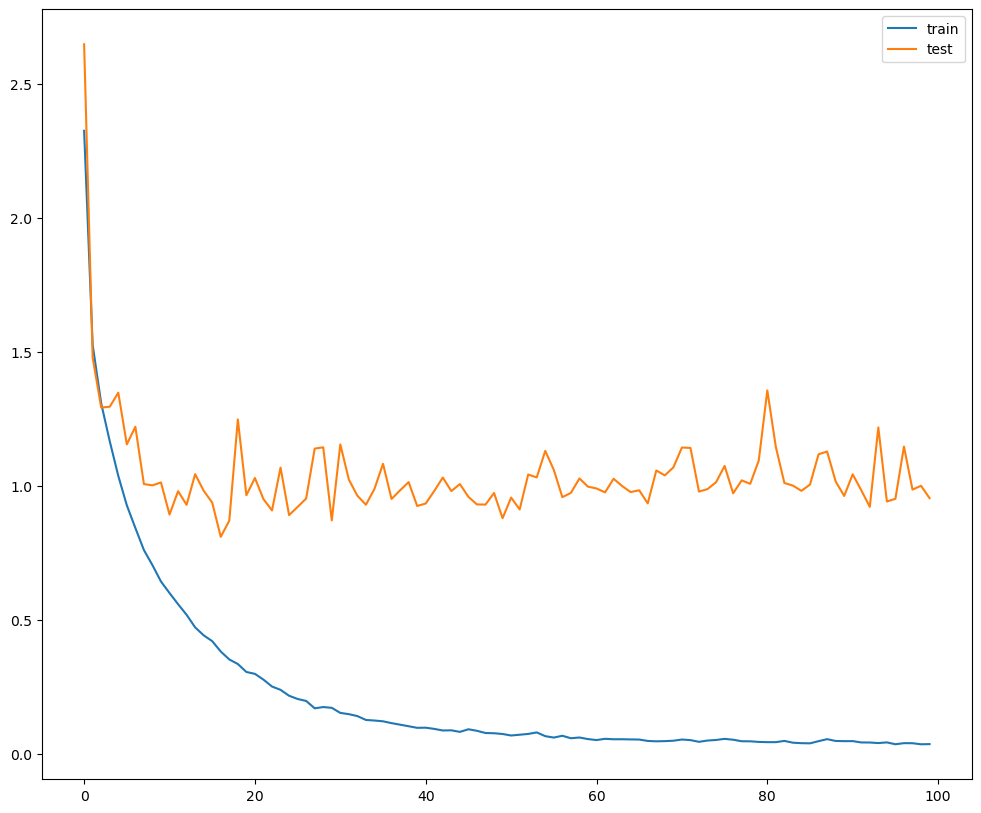

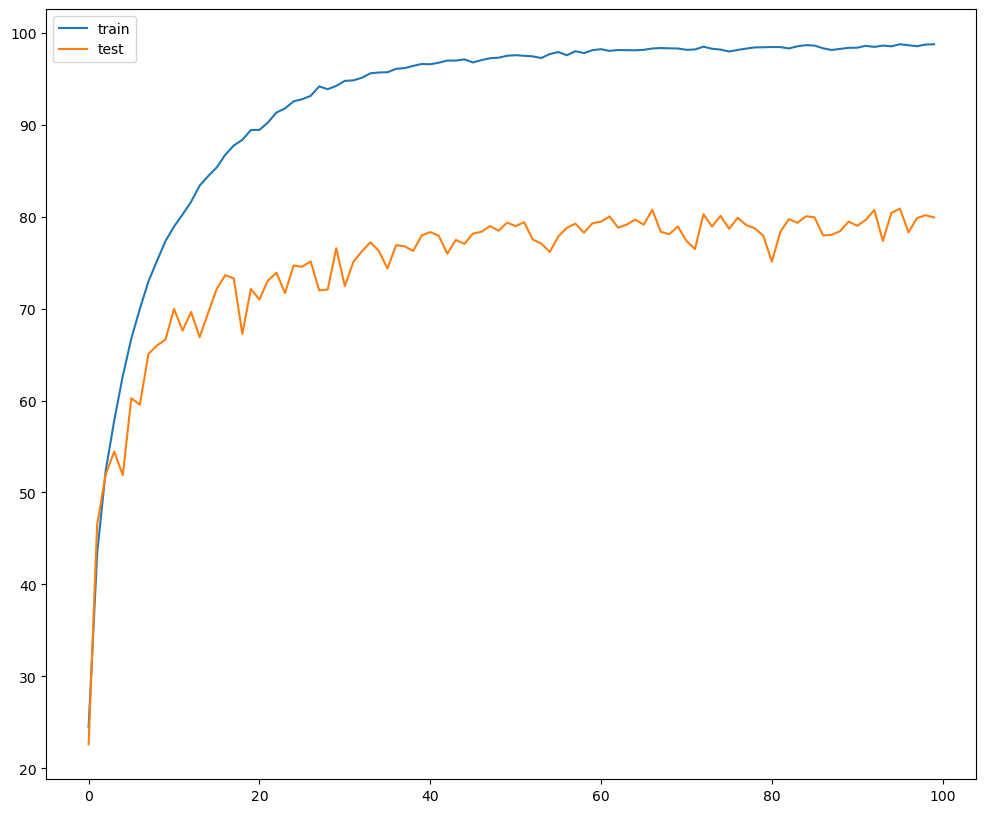

In [3]:
teacher = resnet50(pretrained=False)
teacher_acc,teacher = train(model=teacher,gpu='0,1,2,3,4,5,6,7',fig_name='teacher')
teacher_acc


Epoch 100: Train Loss : 0.026  |  Train Acc : 99.09  |  Test Loss : 0.892  |  Test Acc : 82.36: 100%|██████████| 100/100 [21:09<00:00, 12.69s/it]


82.65


82.65

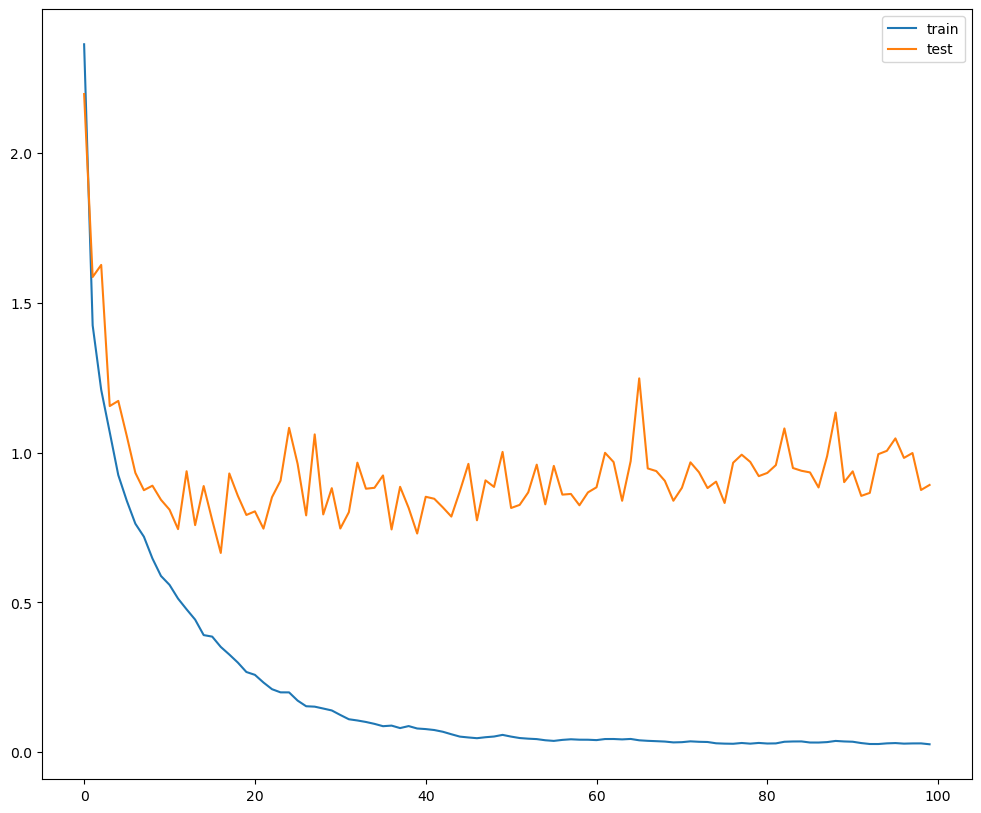

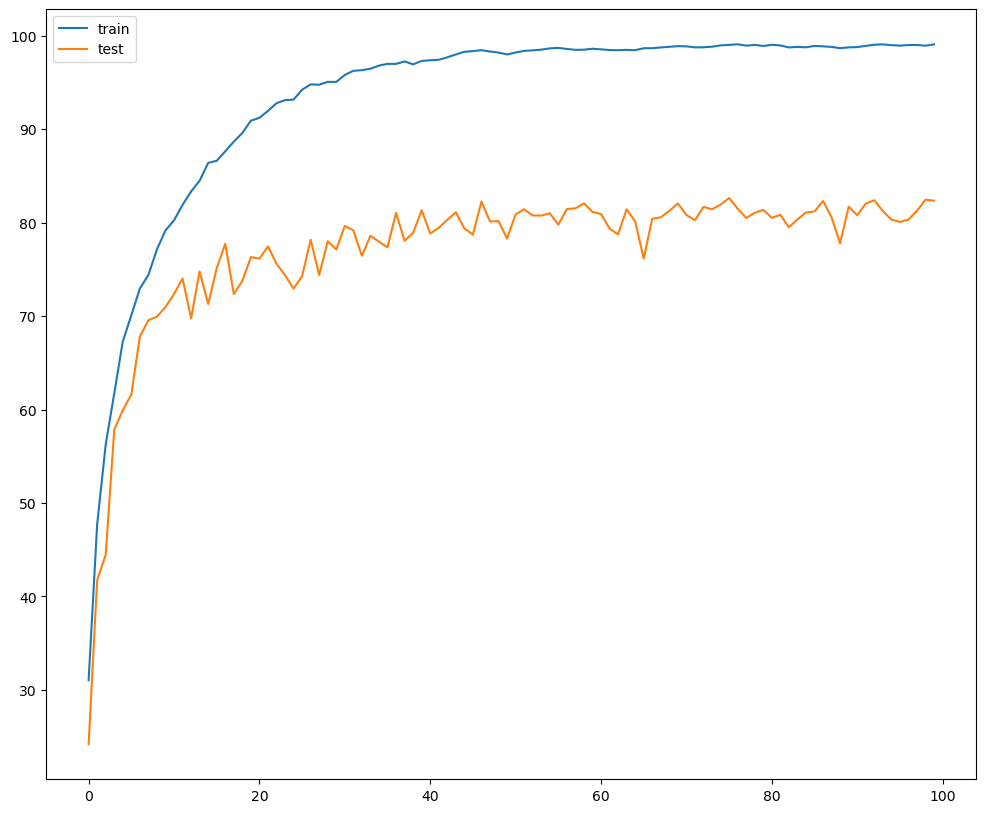

In [4]:
scratch_student = resnet18(pretrained=False)
scratch_student_acc,_ = train(model=scratch_student,gpu='0,1,2,3,4,5,6,7',fig_name='scratch_student')
scratch_student_acc

Epoch 100: Train Loss : 0.025  |  Train Acc : 98.93  |  Test Loss : 1.526  |  Test Acc : 78.51: 100%|██████████| 100/100 [27:55<00:00, 16.76s/it]


82.59


Epoch 100: Train Loss : 0.031  |  Train Acc : 99.05  |  Test Loss : 1.853  |  Test Acc : 82.48: 100%|██████████| 100/100 [27:38<00:00, 16.58s/it]


83.37


Epoch 100: Train Loss : 0.038  |  Train Acc : 99.06  |  Test Loss : 2.450  |  Test Acc : 81.98: 100%|██████████| 100/100 [27:36<00:00, 16.56s/it]


83.81


Epoch 100: Train Loss : 0.055  |  Train Acc : 98.92  |  Test Loss : 2.834  |  Test Acc : 82.97: 100%|██████████| 100/100 [27:37<00:00, 16.57s/it]


83.75


Epoch 100: Train Loss : 0.066  |  Train Acc : 98.86  |  Test Loss : 3.485  |  Test Acc : 82.68: 100%|██████████| 100/100 [28:04<00:00, 16.84s/it]


84.35000000000001


Epoch 100: Train Loss : 0.082  |  Train Acc : 98.64  |  Test Loss : 3.650  |  Test Acc : 82.89: 100%|██████████| 100/100 [27:55<00:00, 16.75s/it]


84.39


Epoch 100: Train Loss : 0.091  |  Train Acc : 98.62  |  Test Loss : 3.585  |  Test Acc : 84.30: 100%|██████████| 100/100 [27:47<00:00, 16.68s/it]


84.58


Epoch 100: Train Loss : 0.102  |  Train Acc : 98.52  |  Test Loss : 4.205  |  Test Acc : 82.91: 100%|██████████| 100/100 [27:58<00:00, 16.78s/it]


84.11


Epoch 100: Train Loss : 0.126  |  Train Acc : 98.34  |  Test Loss : 4.390  |  Test Acc : 82.09: 100%|██████████| 100/100 [27:54<00:00, 16.74s/it]


84.71


Epoch 100: Train Loss : 0.128  |  Train Acc : 98.37  |  Test Loss : 4.328  |  Test Acc : 83.48: 100%|██████████| 100/100 [27:54<00:00, 16.75s/it]


85.03


[82.59,
 83.37,
 83.81,
 83.75,
 84.35000000000001,
 84.39,
 84.58,
 84.11,
 84.71,
 85.03]

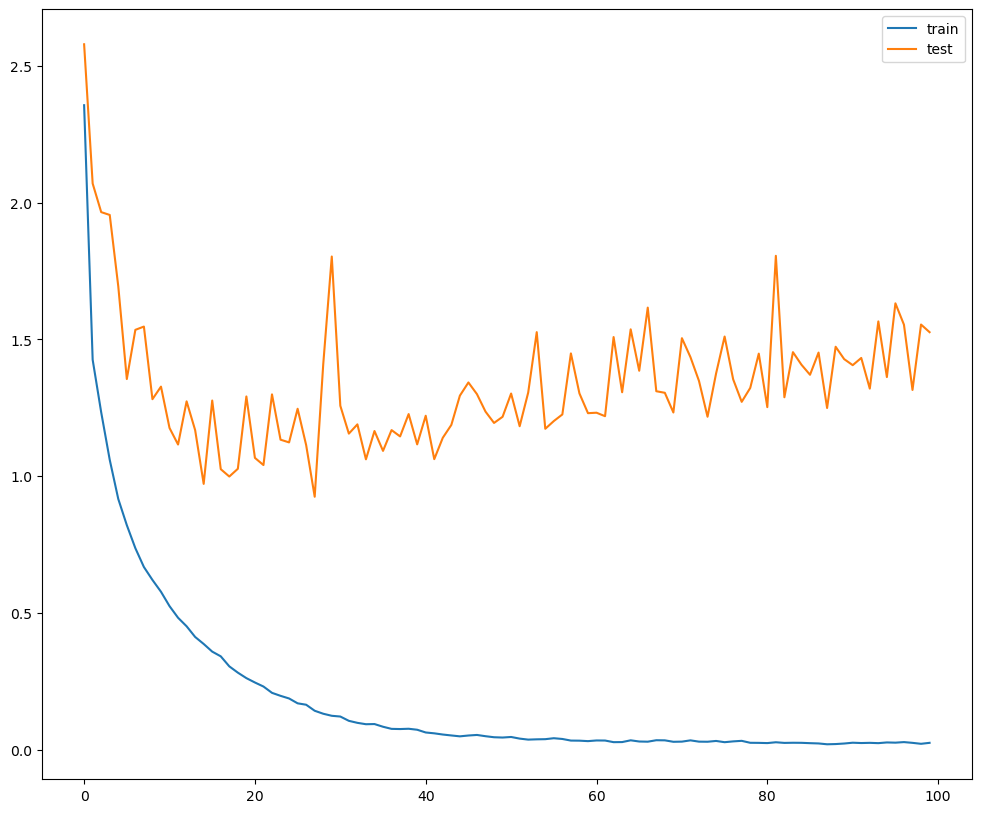

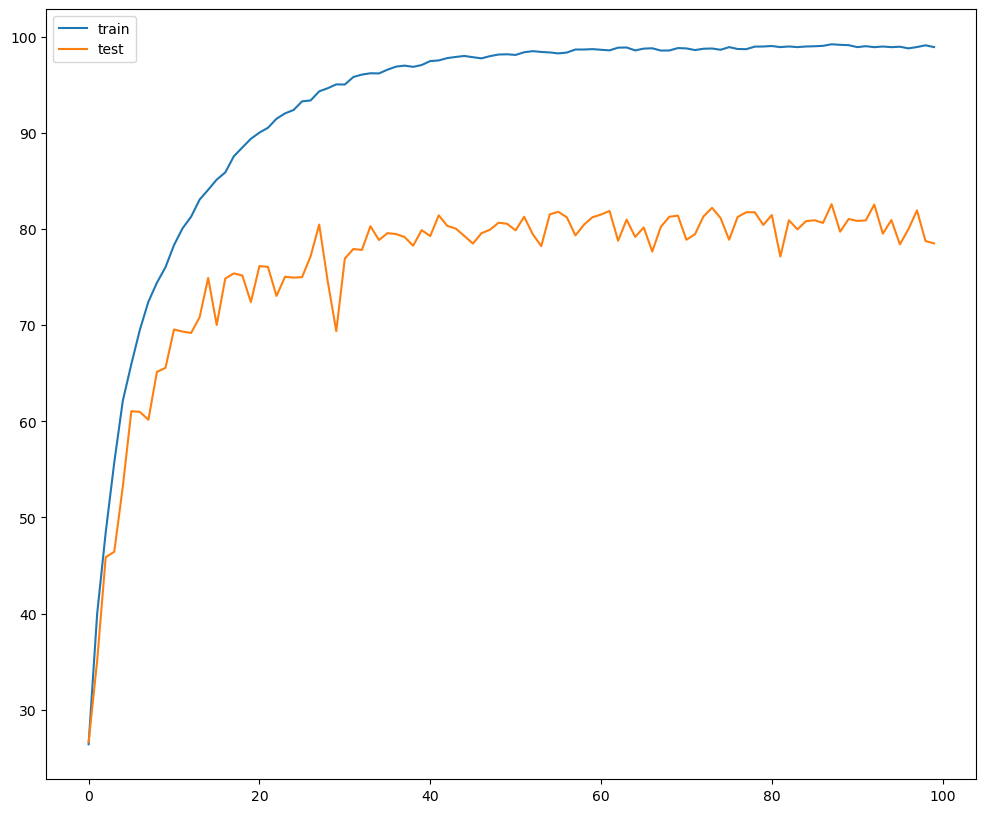

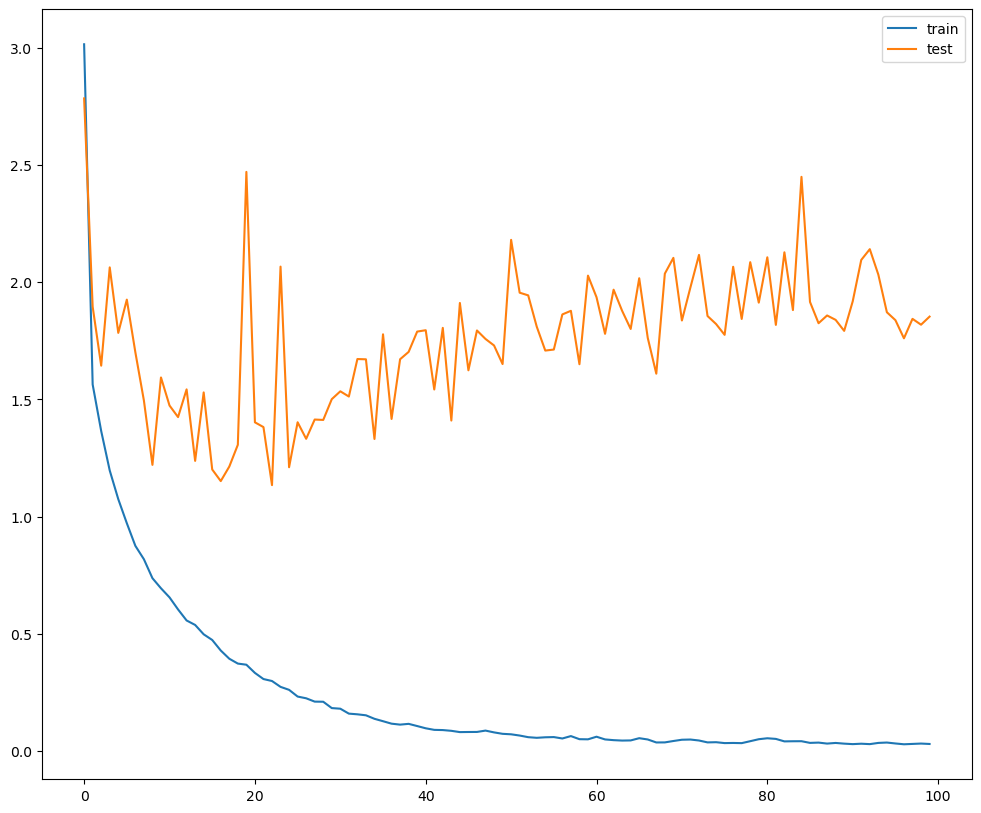

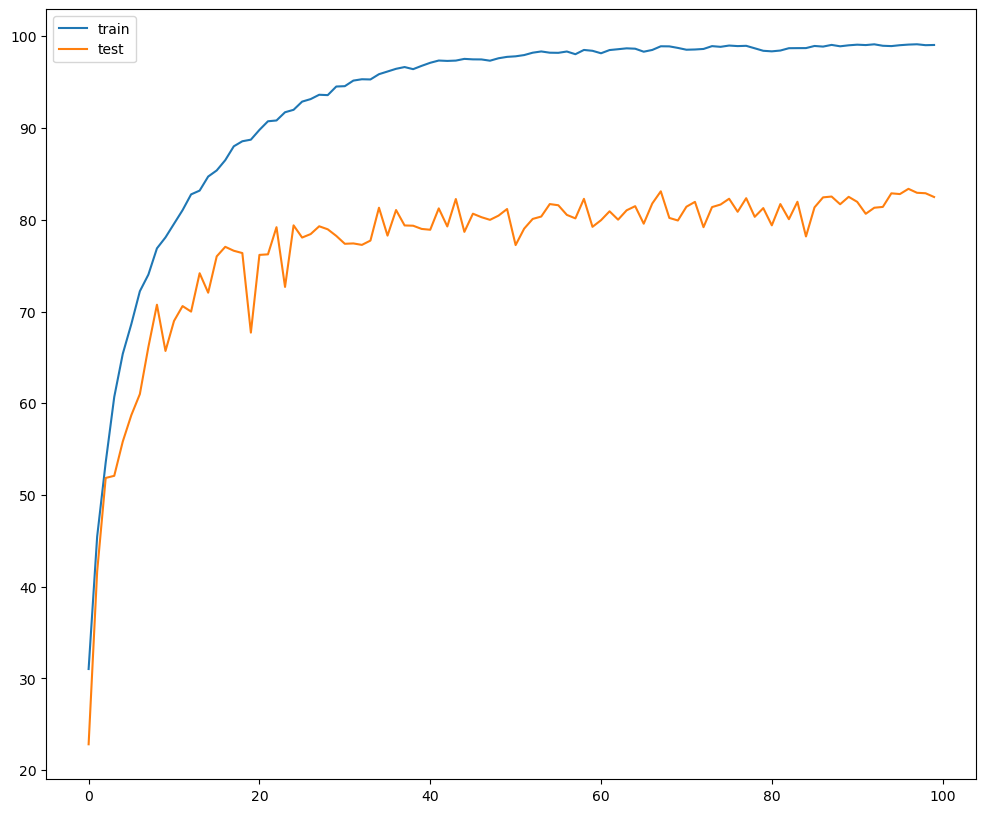

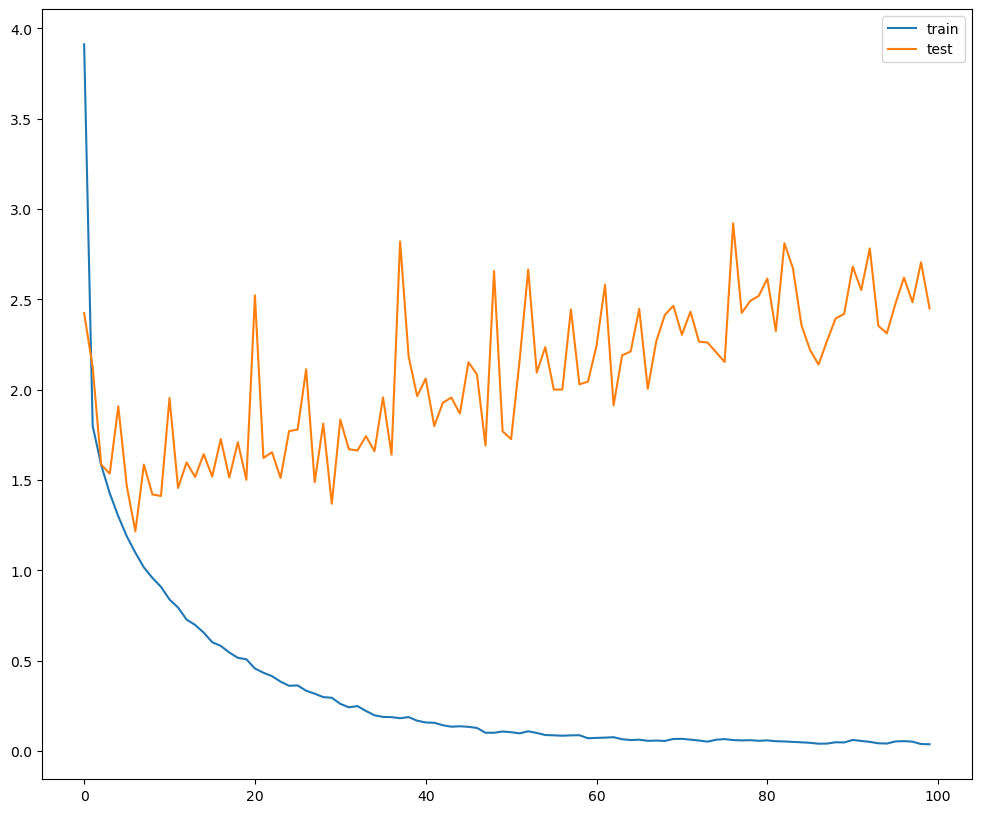

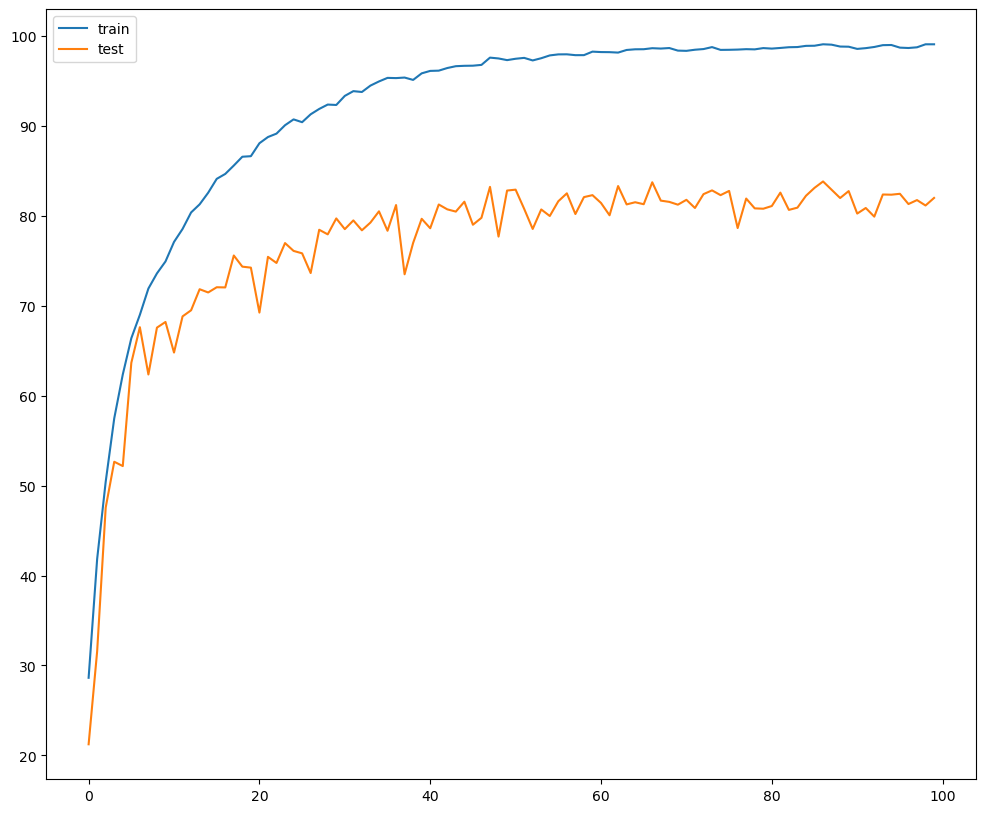

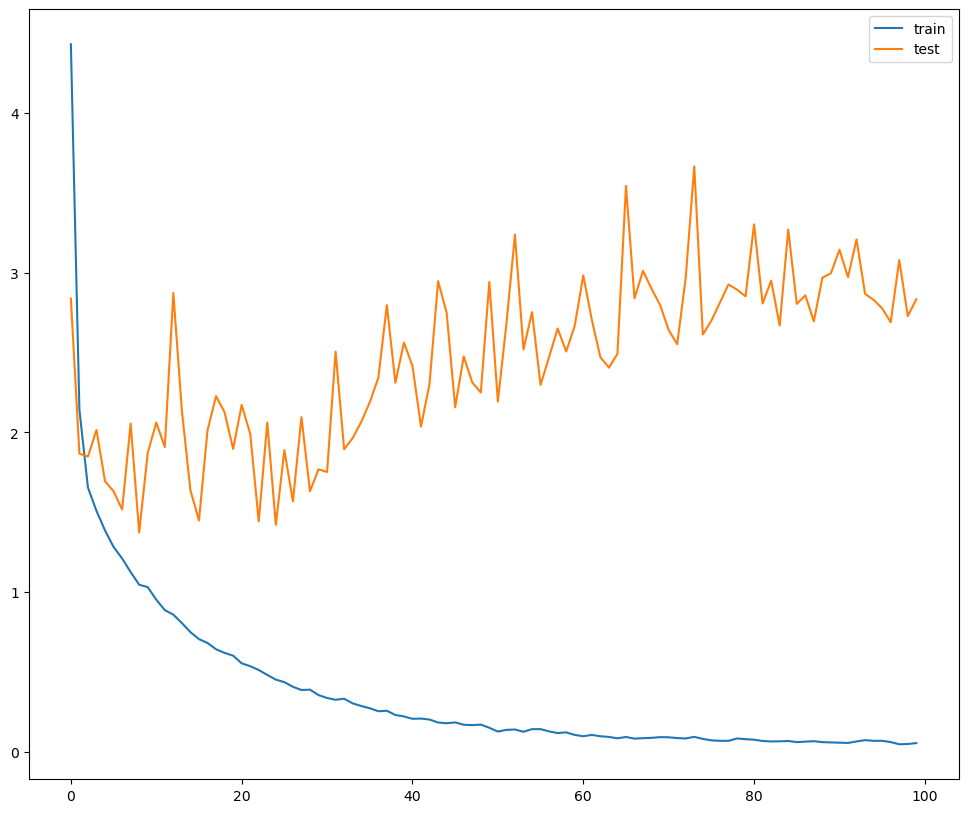

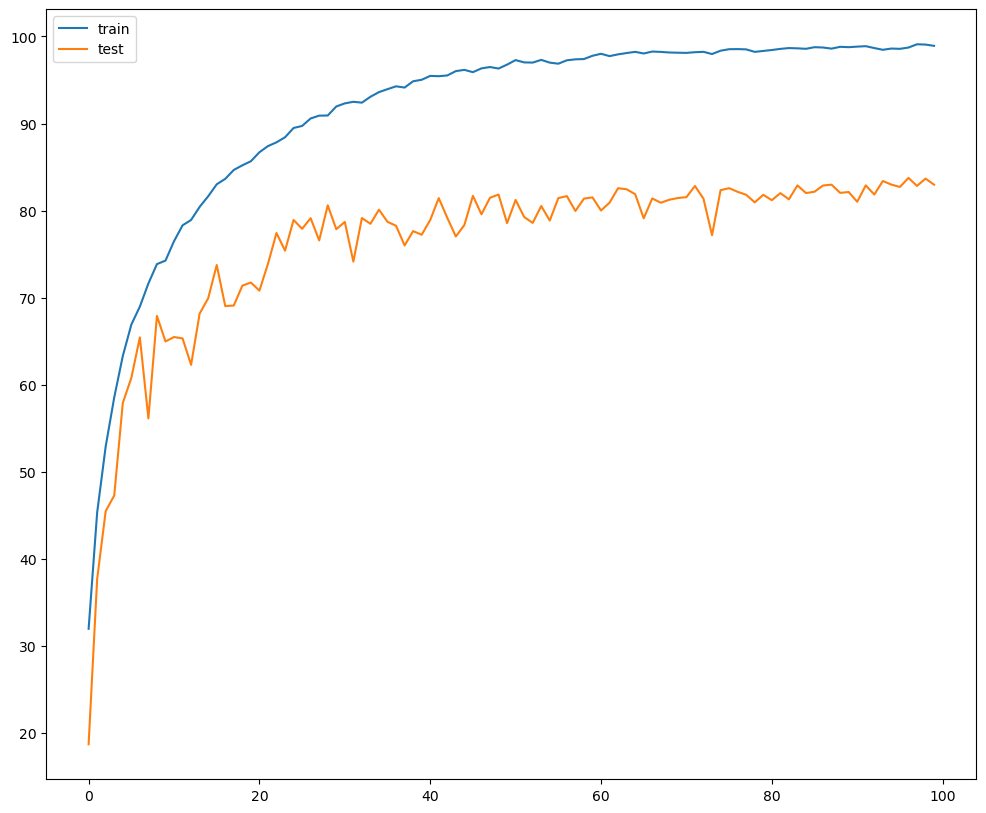

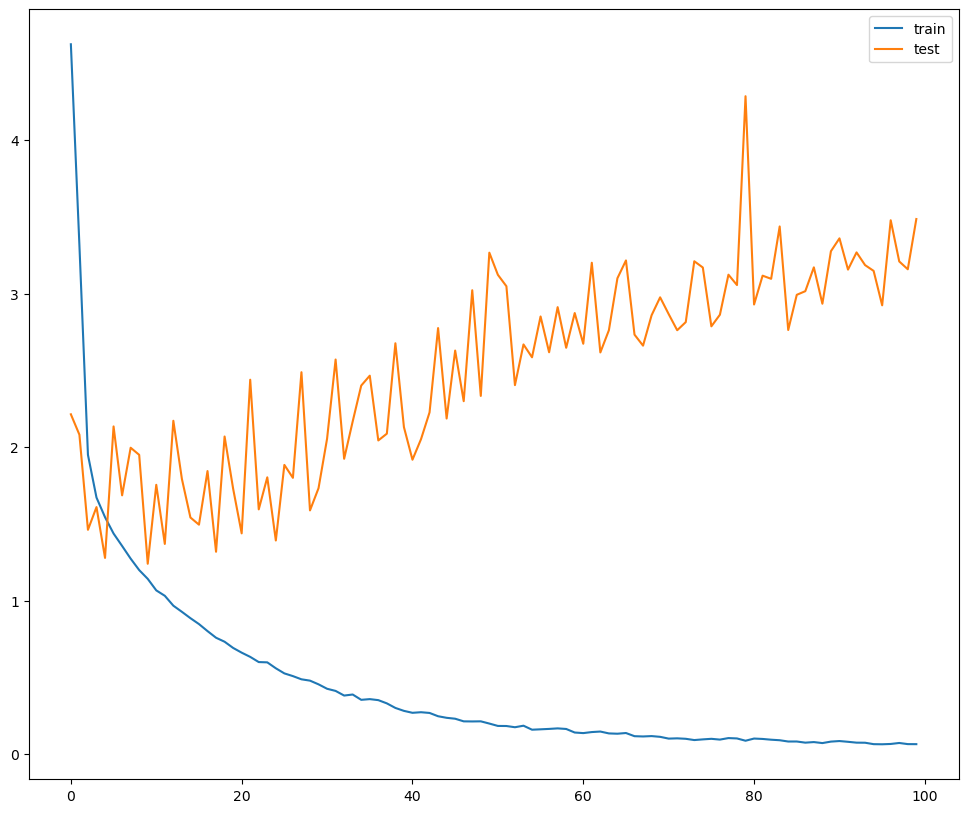

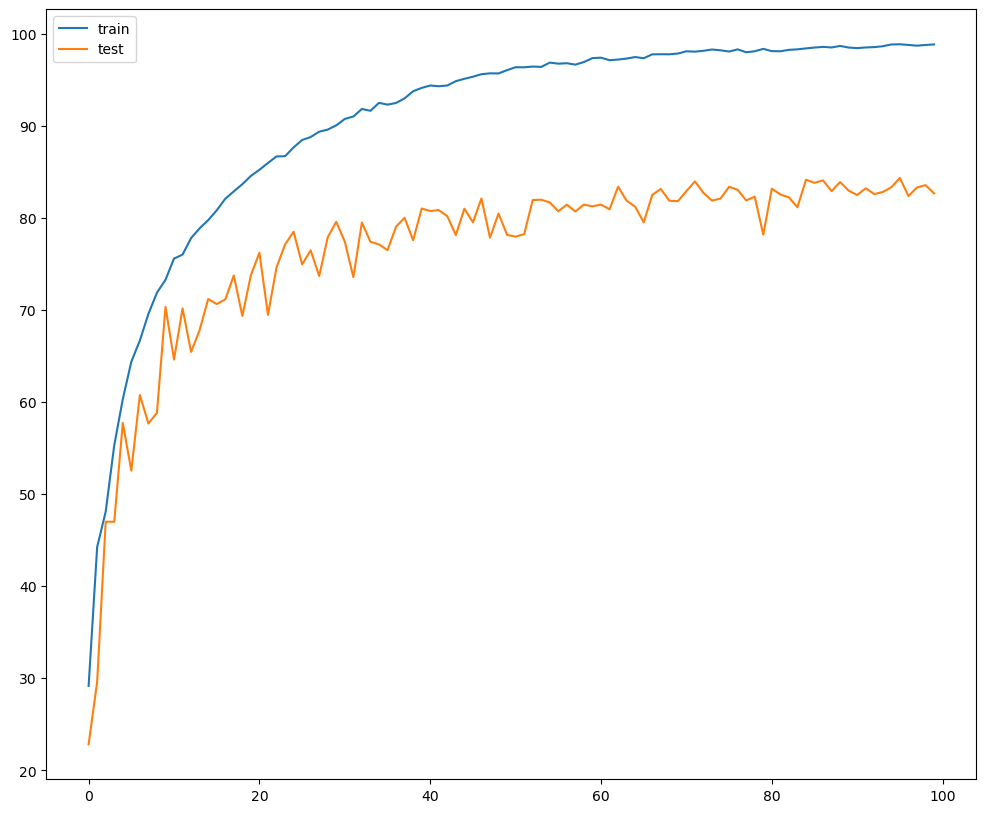

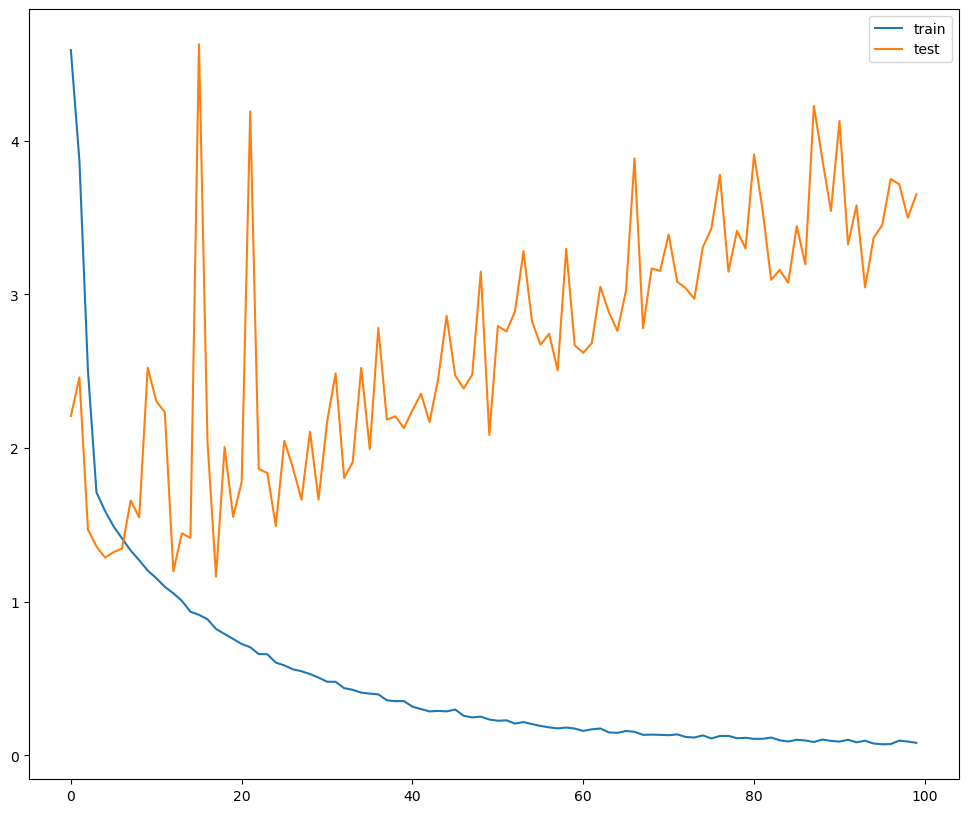

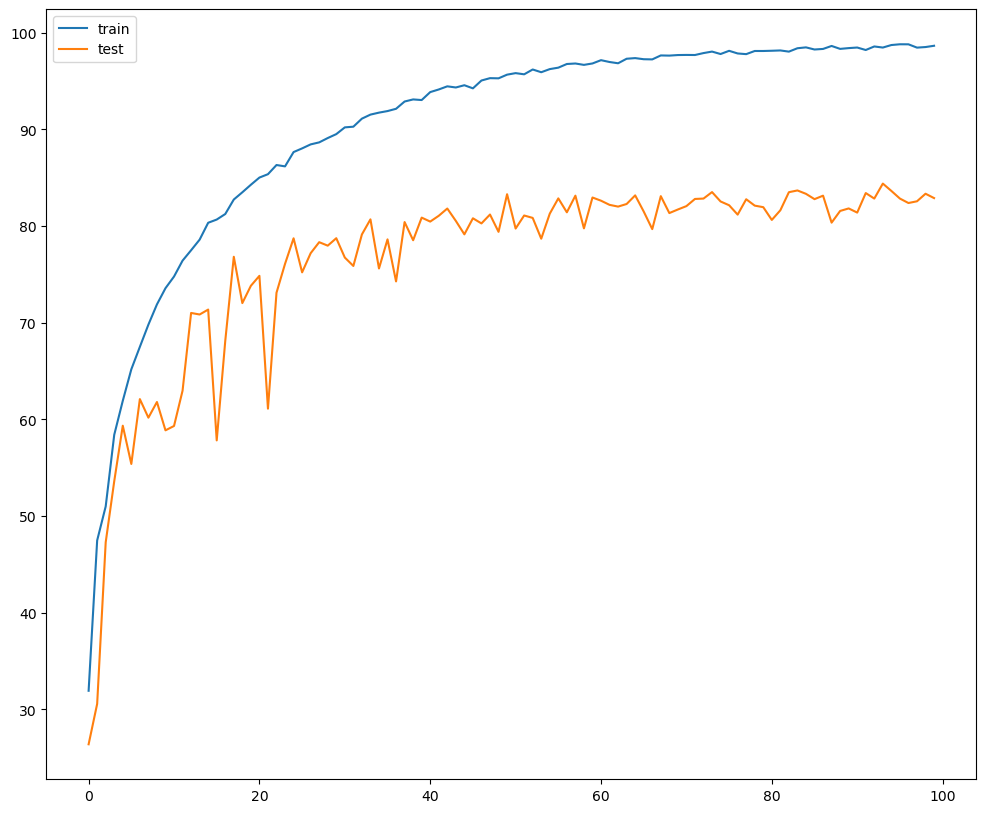

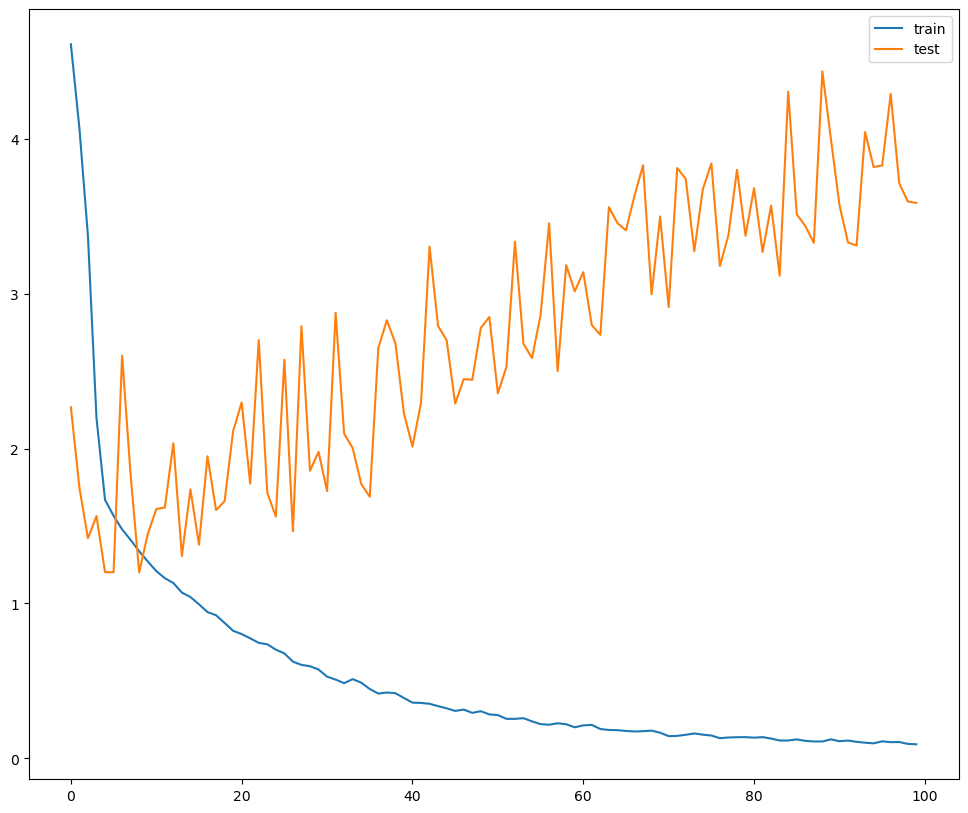

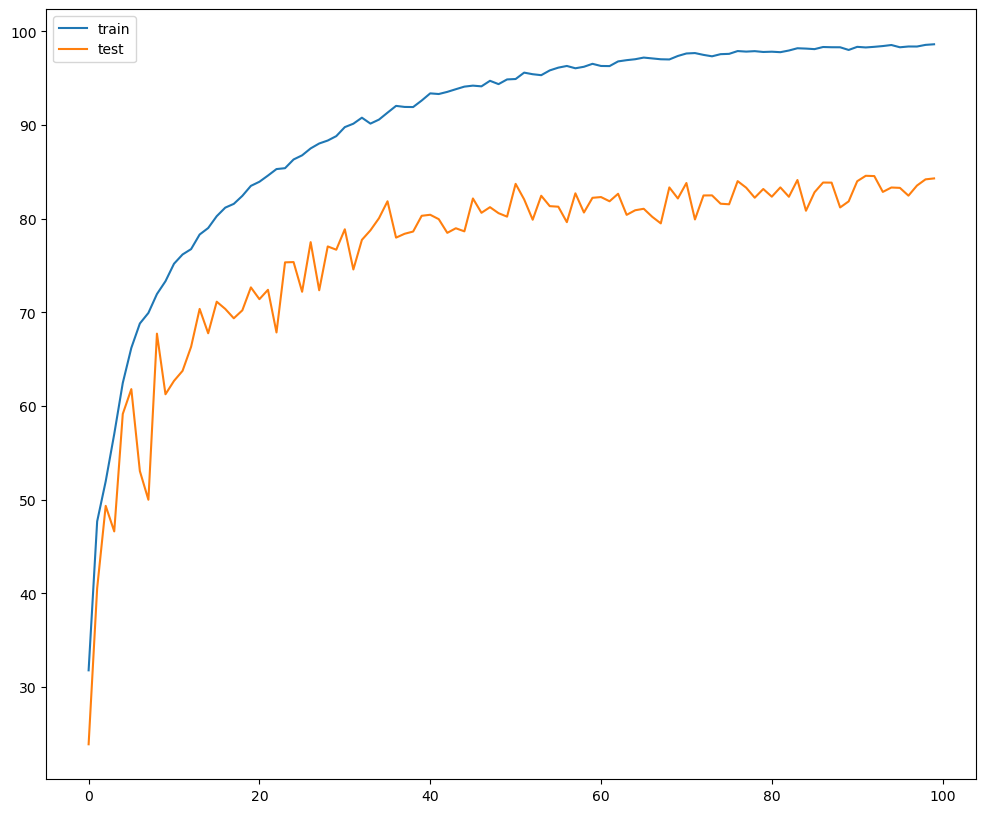

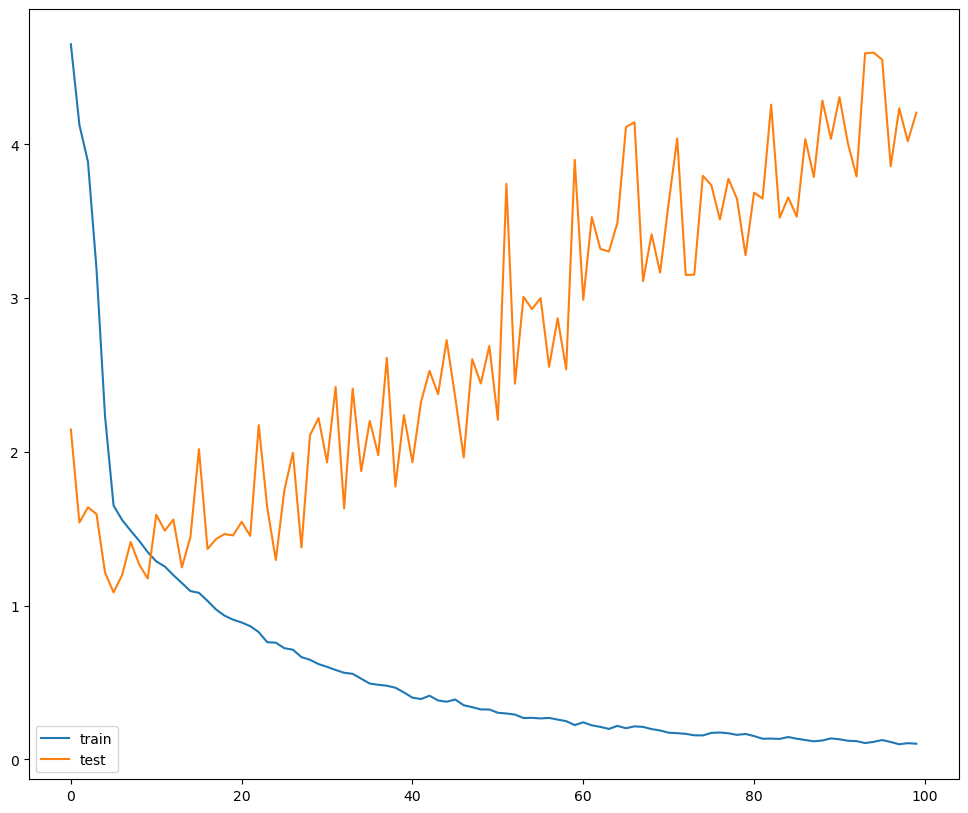

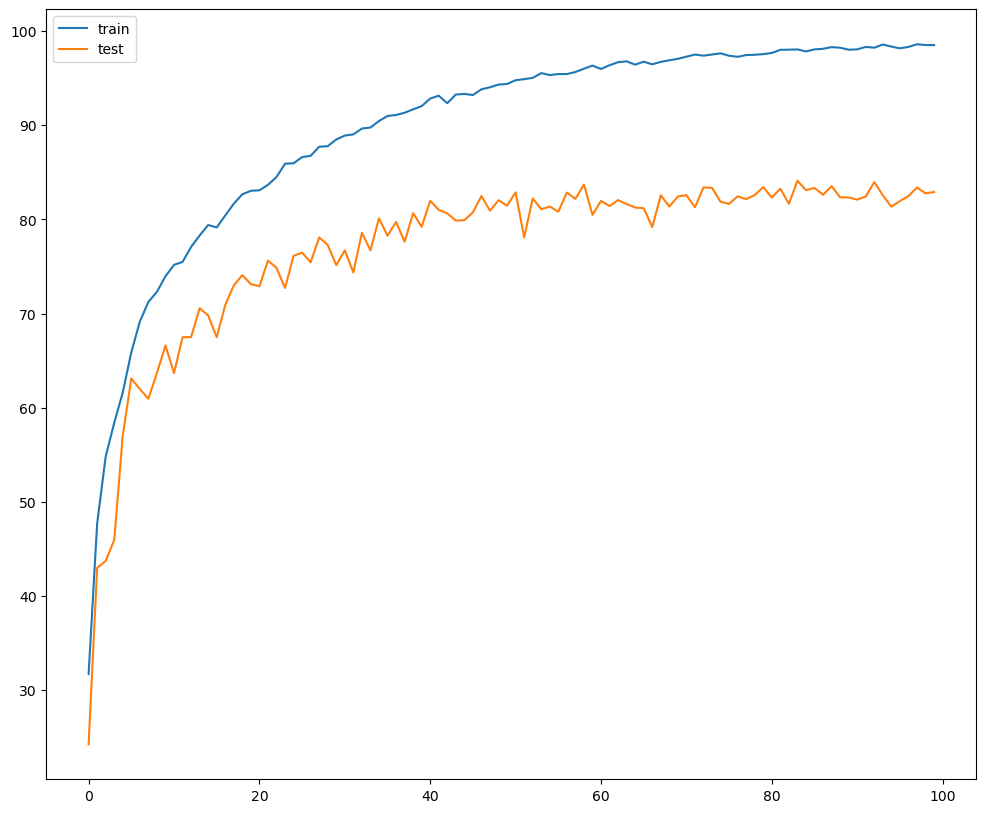

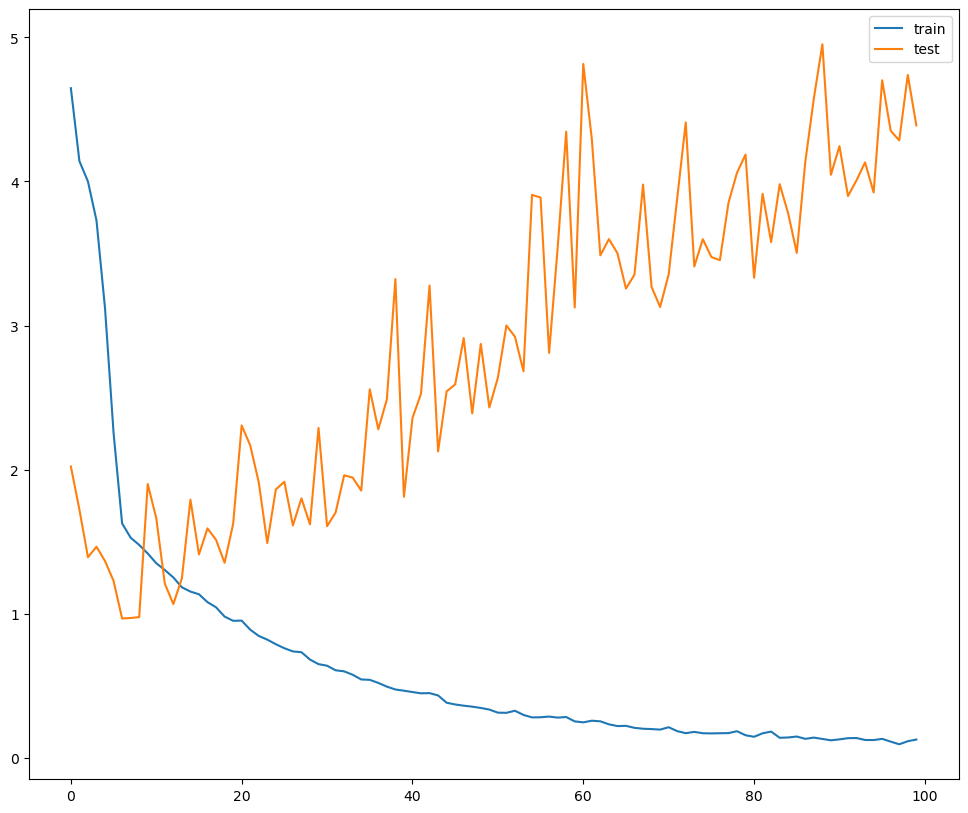

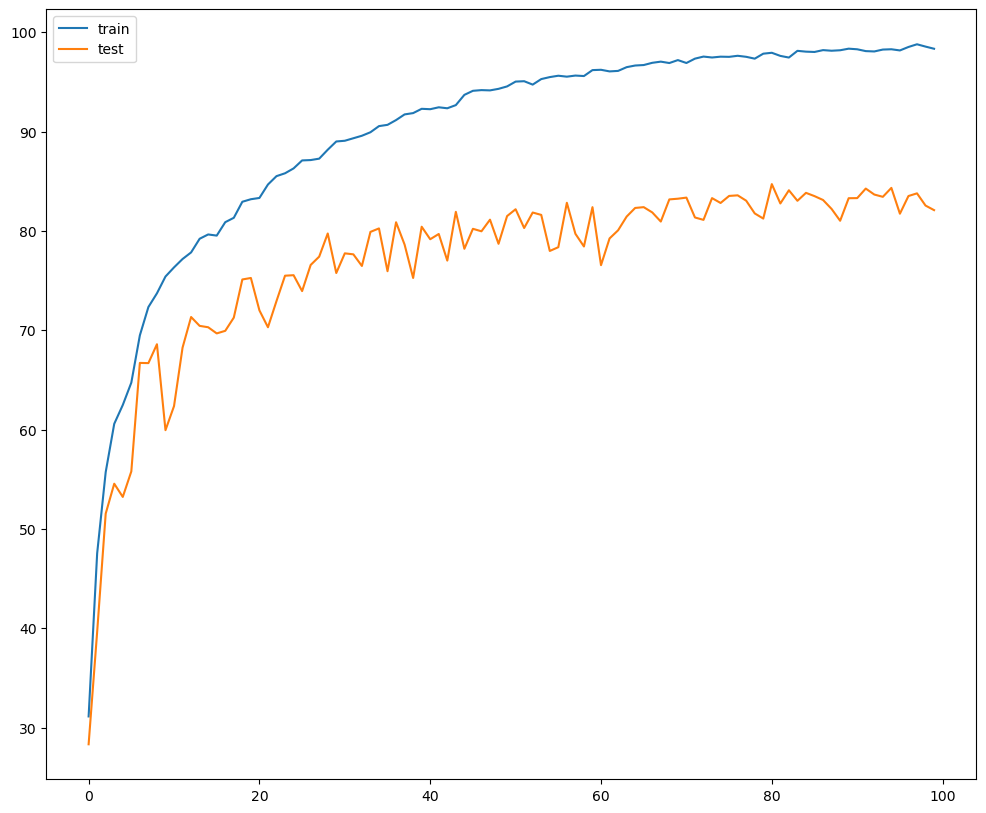

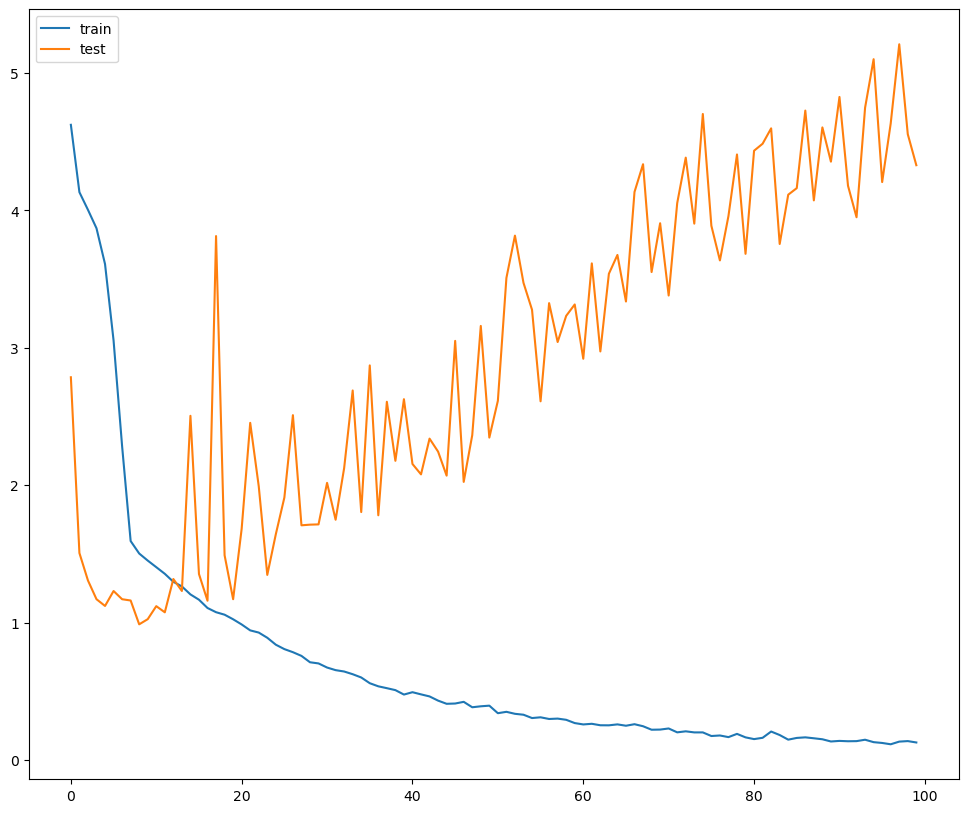

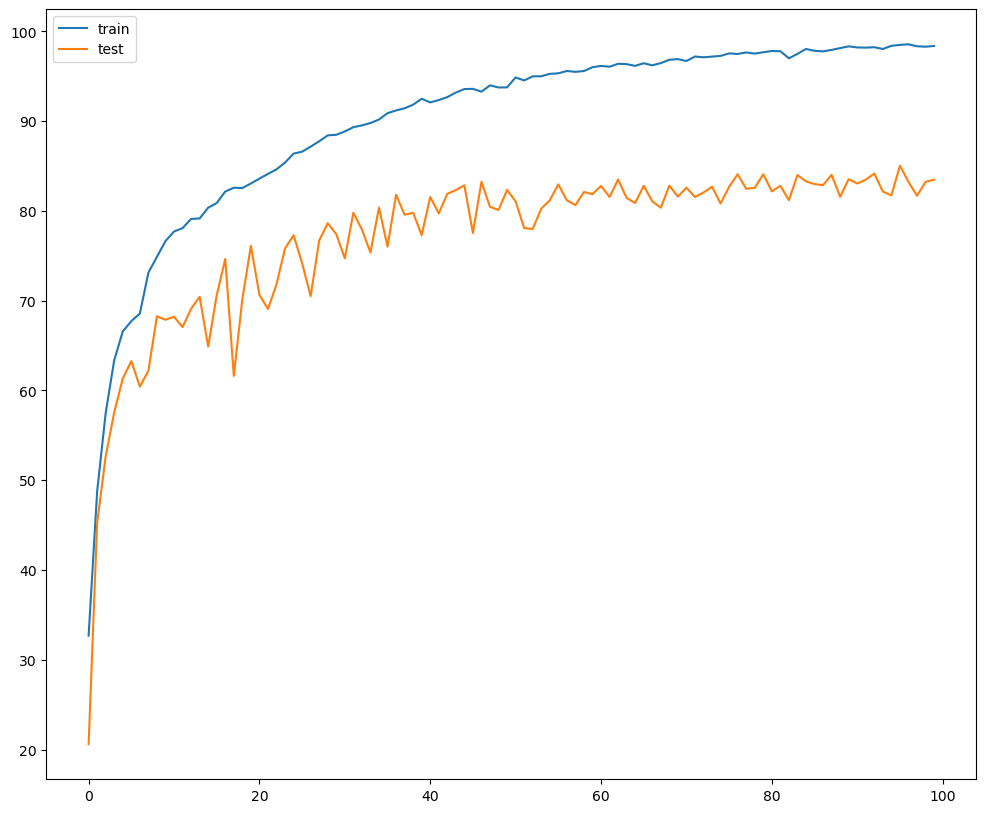

In [5]:
temp_list = list(range(1,11))
acc_list = []
for temp in temp_list:
    student = resnet18(pretrained=False)
    student_acc,_ = train(model=student,gpu='0,1,2,3,4,5,6,7',fig_name=f'50student_temp{temp}',kd_tag=True,teacher=teacher,temp=temp)
    acc_list.append(student_acc)

acc_list

Text(0.5, 1.0, 'acc-temperature')

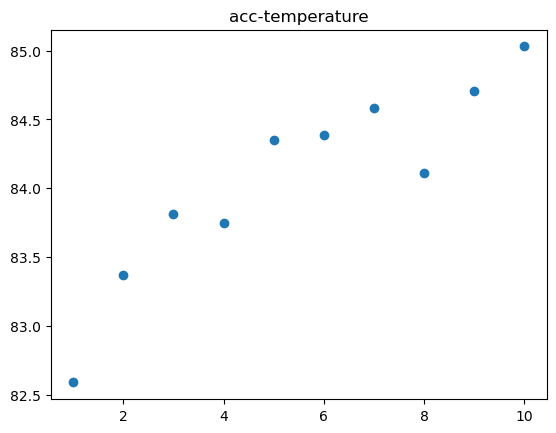

In [6]:
plt.figure()
plt.scatter(temp_list,acc_list)
plt.title('acc-temperature')

Epoch 100: Train Loss : 0.036  |  Train Acc : 98.74  |  Test Loss : 0.818  |  Test Acc : 83.37: 100%|██████████| 100/100 [25:01<00:00, 15.02s/it]


84.67


84.67

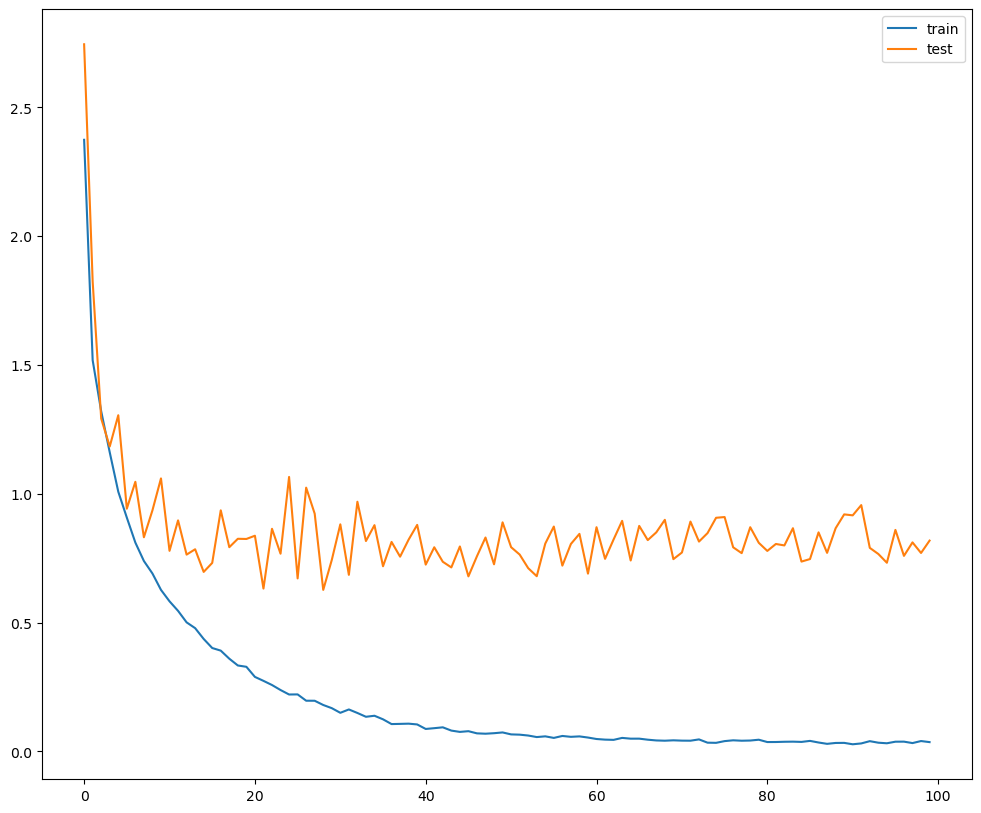

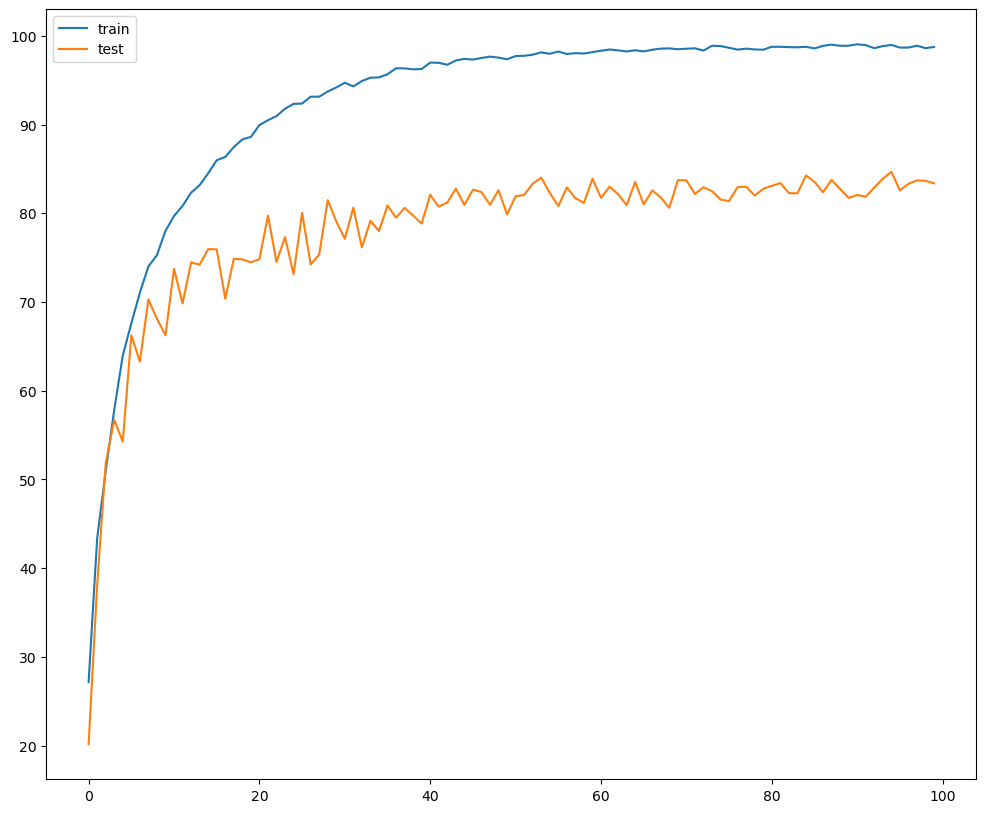

In [7]:
teacher = resnet34(pretrained=False)
teacher_acc,teacher = train(model=teacher,gpu='0,1,2,3,4,5,6,7',fig_name='teacher34')
teacher_acc

Epoch 100: Train Loss : 0.025  |  Train Acc : 98.95  |  Test Loss : 1.410  |  Test Acc : 80.87: 100%|██████████| 100/100 [26:27<00:00, 15.87s/it]


82.88


Epoch 100: Train Loss : 0.042  |  Train Acc : 98.74  |  Test Loss : 2.083  |  Test Acc : 80.43: 100%|██████████| 100/100 [26:21<00:00, 15.82s/it]


83.78


Epoch 100: Train Loss : 0.039  |  Train Acc : 99.05  |  Test Loss : 2.487  |  Test Acc : 82.09: 100%|██████████| 100/100 [26:12<00:00, 15.72s/it]


83.33


Epoch 100: Train Loss : 0.049  |  Train Acc : 99.05  |  Test Loss : 2.673  |  Test Acc : 83.98: 100%|██████████| 100/100 [26:21<00:00, 15.82s/it]


83.98


Epoch 100: Train Loss : 0.060  |  Train Acc : 98.93  |  Test Loss : 3.030  |  Test Acc : 83.80: 100%|██████████| 100/100 [26:12<00:00, 15.73s/it]


83.8


Epoch 100: Train Loss : 0.100  |  Train Acc : 98.34  |  Test Loss : 4.184  |  Test Acc : 81.68: 100%|██████████| 100/100 [26:43<00:00, 16.04s/it]


83.25


Epoch 100: Train Loss : 0.104  |  Train Acc : 98.39  |  Test Loss : 3.847  |  Test Acc : 82.90: 100%|██████████| 100/100 [26:25<00:00, 15.86s/it]


85.2


Epoch 100: Train Loss : 0.091  |  Train Acc : 98.71  |  Test Loss : 3.853  |  Test Acc : 84.33: 100%|██████████| 100/100 [29:18<00:00, 17.58s/it]


84.33


Epoch 100: Train Loss : 0.111  |  Train Acc : 98.52  |  Test Loss : 3.921  |  Test Acc : 84.22: 100%|██████████| 100/100 [29:25<00:00, 17.66s/it]


84.85000000000001


Epoch 100: Train Loss : 0.148  |  Train Acc : 98.09  |  Test Loss : 5.281  |  Test Acc : 82.21: 100%|██████████| 100/100 [37:29<00:00, 22.49s/it]


84.35000000000001


[82.88,
 83.78,
 83.33,
 83.98,
 83.8,
 83.25,
 85.2,
 84.33,
 84.85000000000001,
 84.35000000000001]

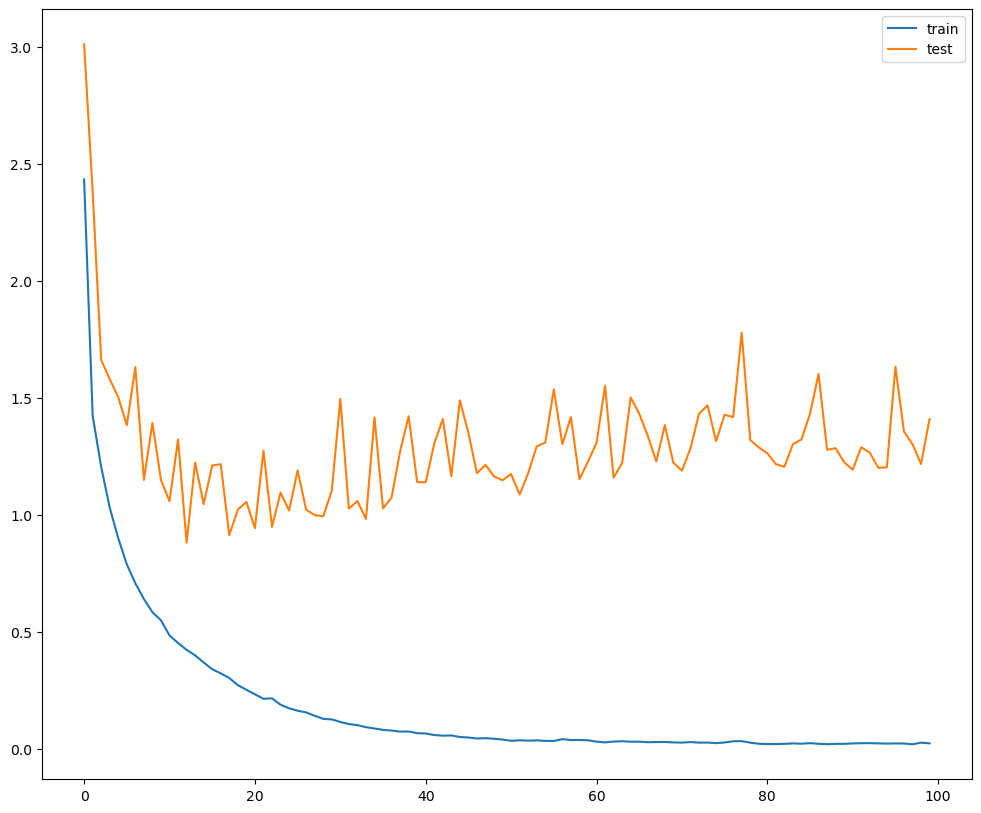

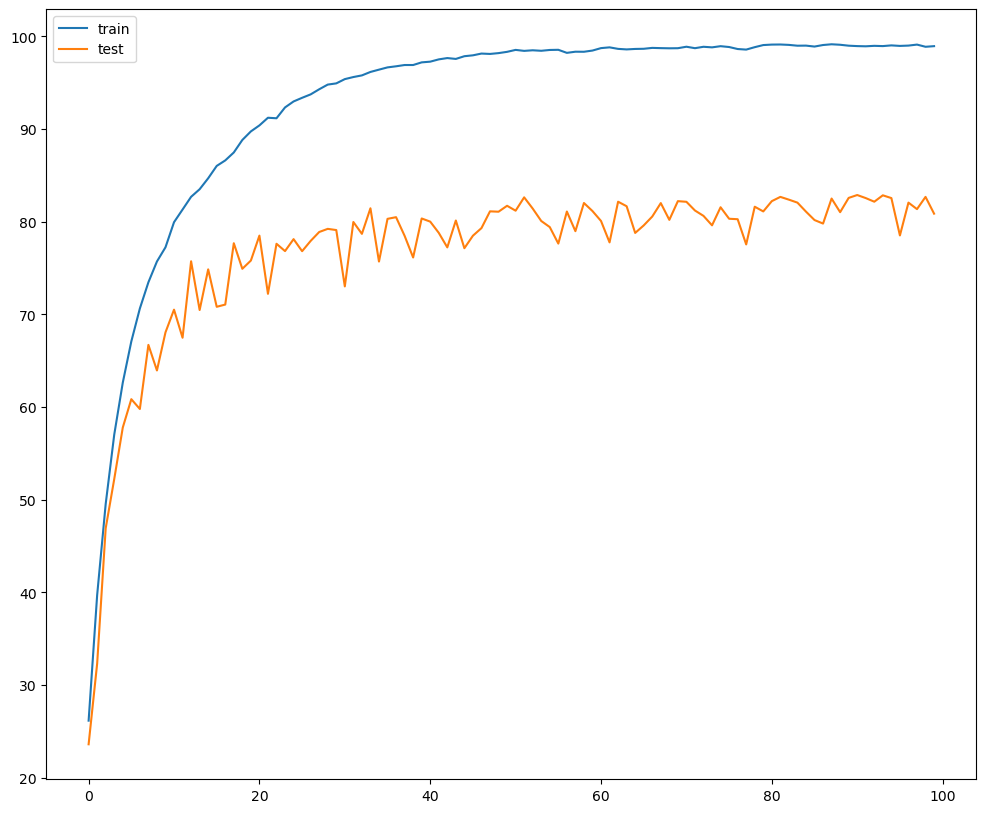

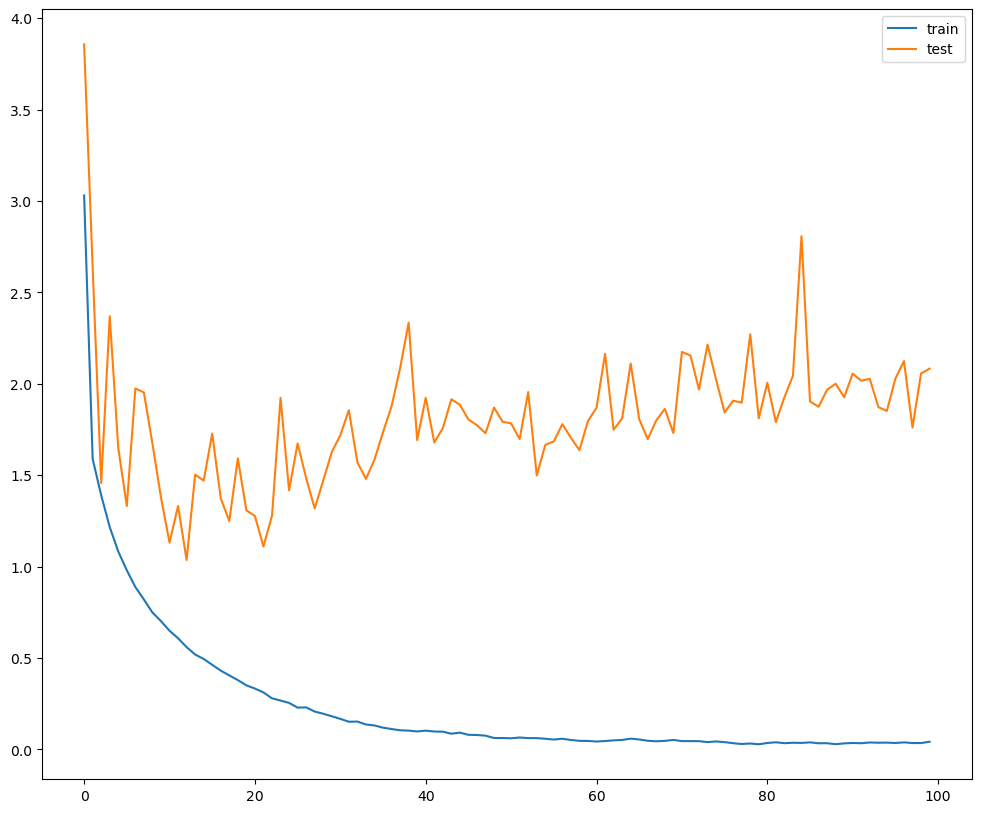

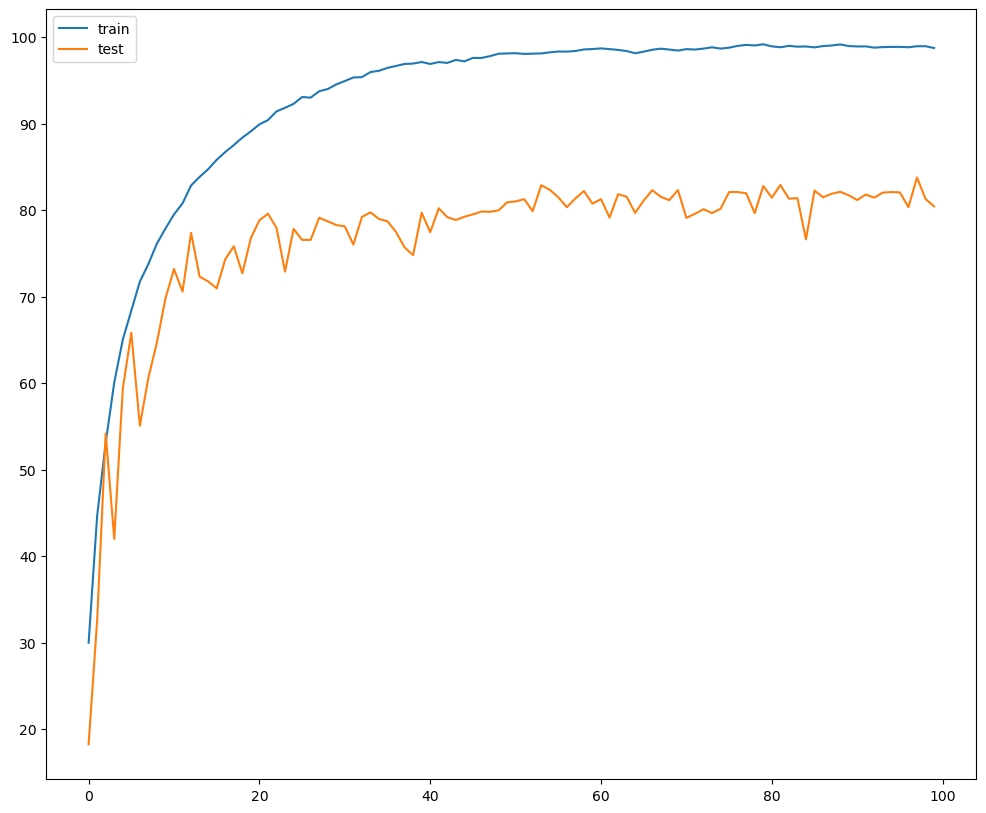

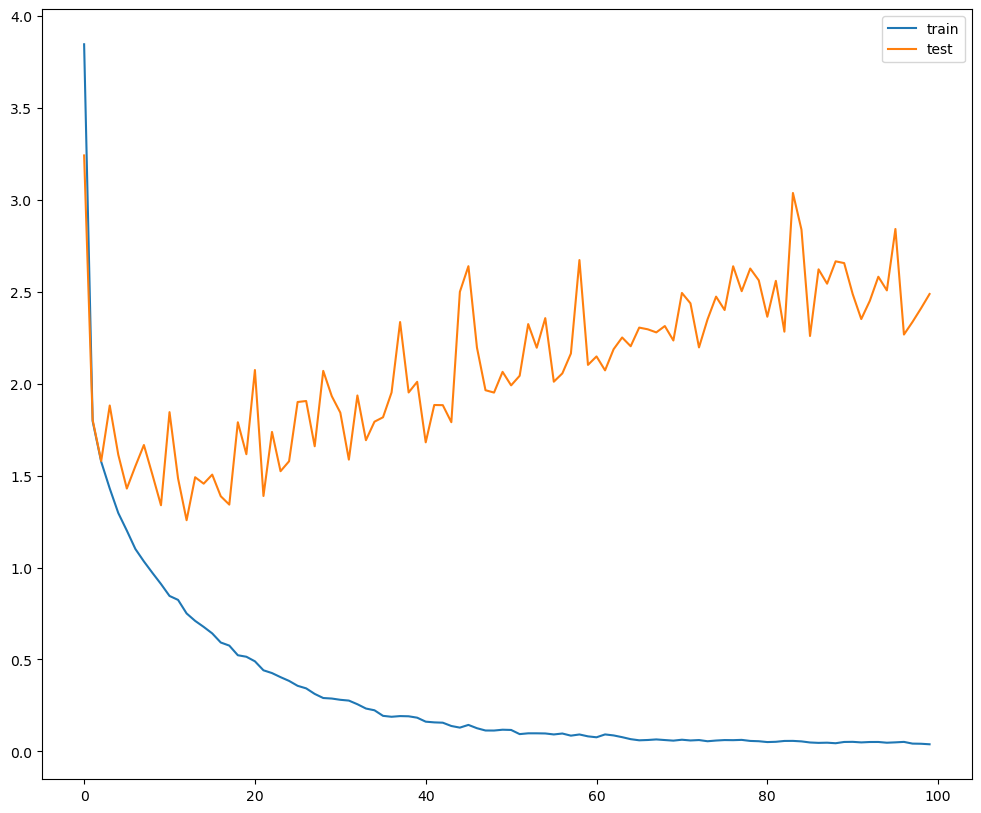

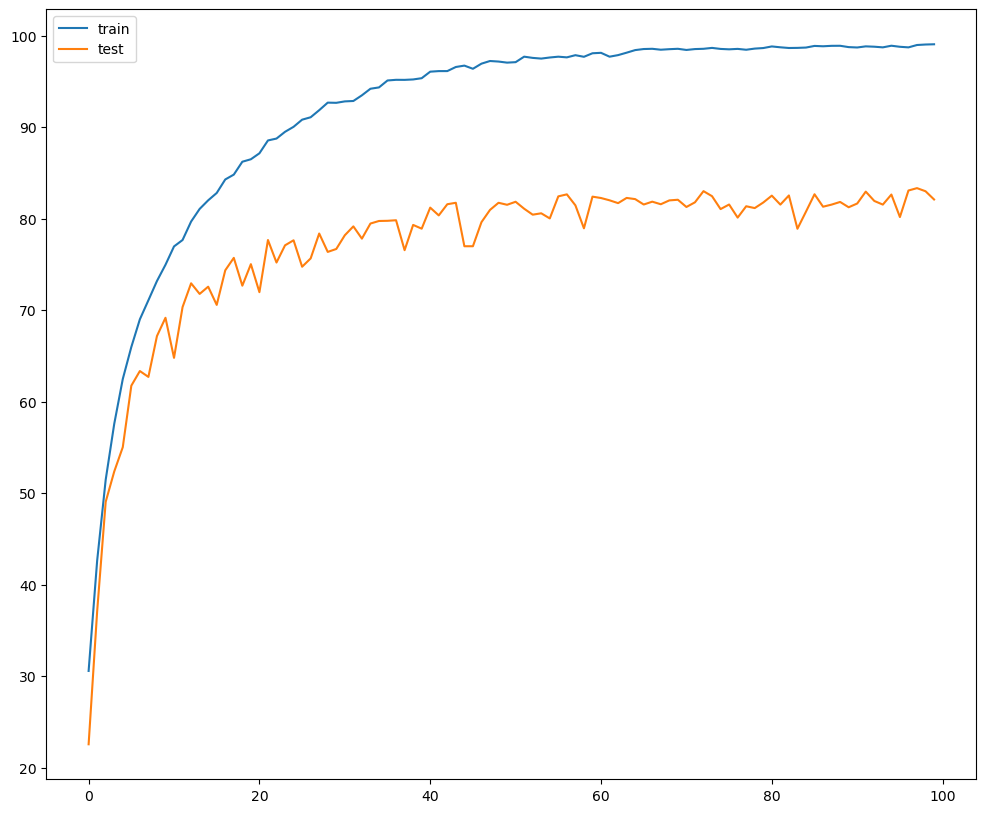

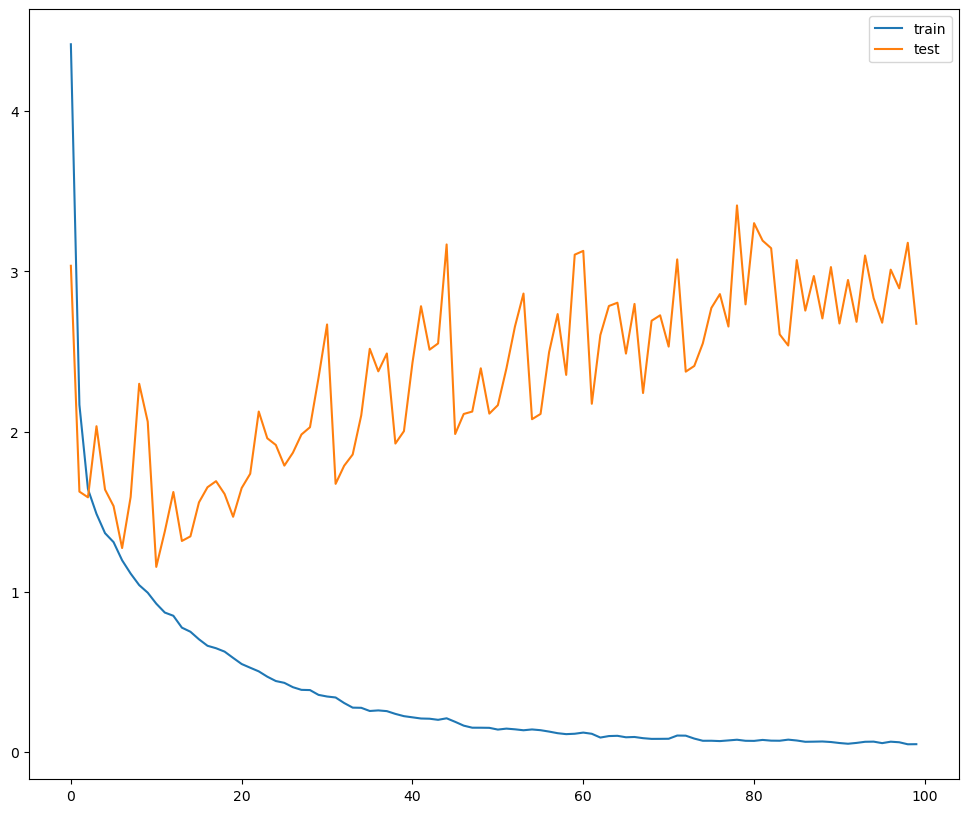

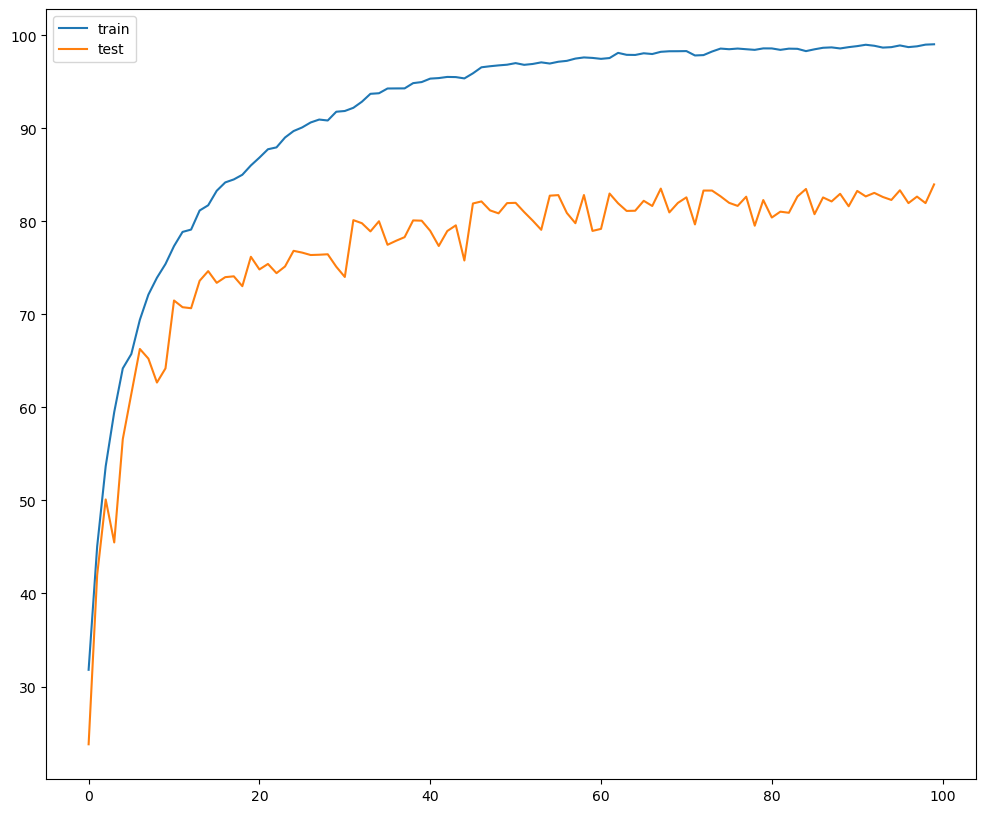

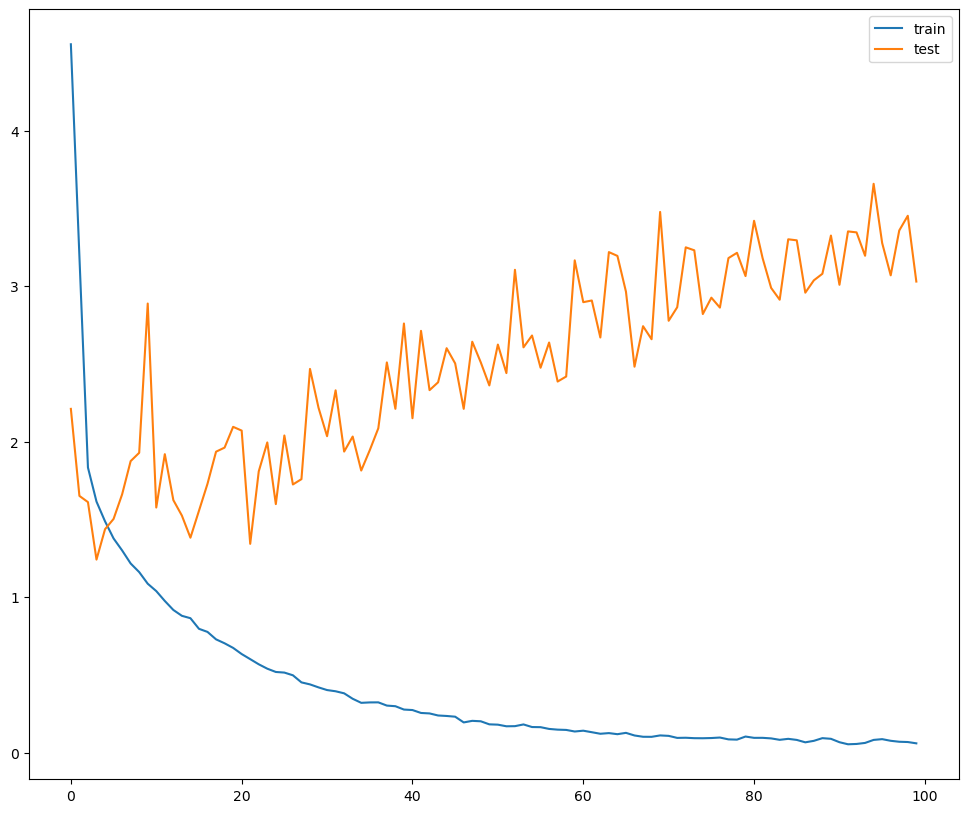

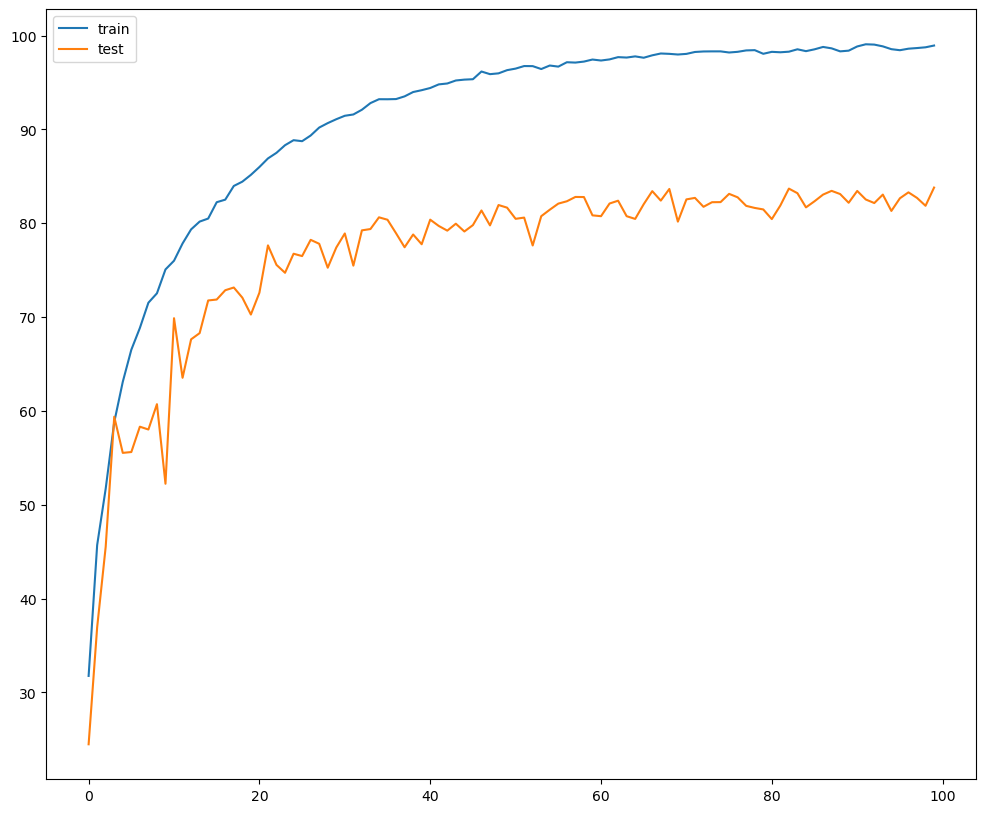

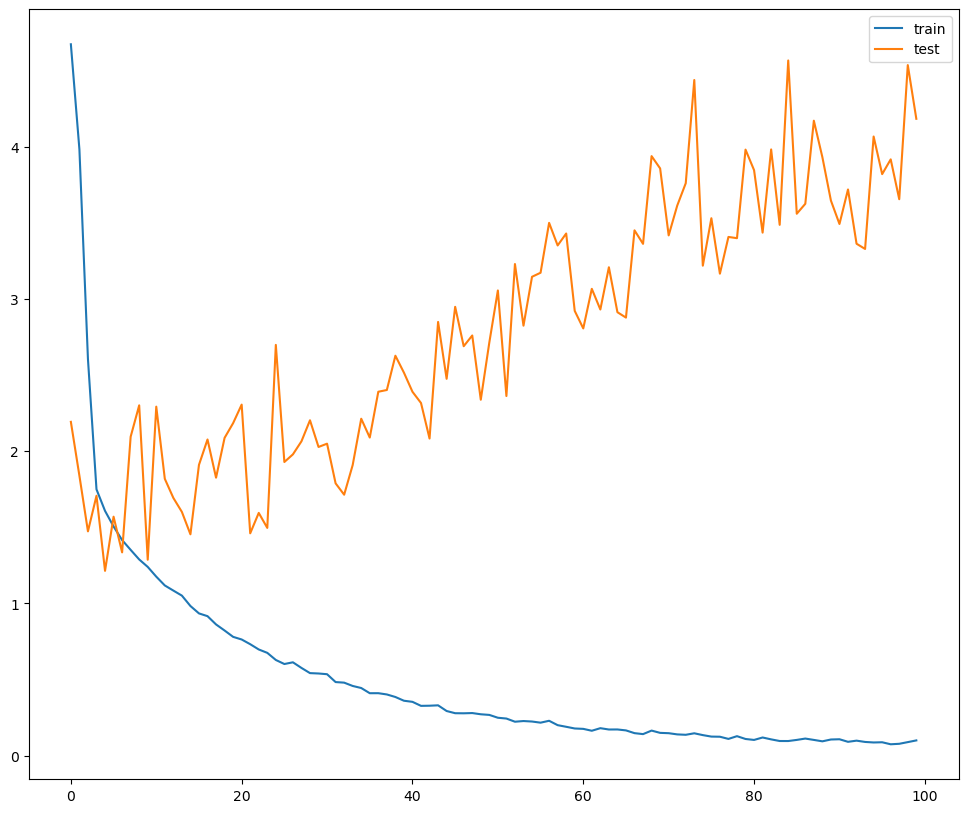

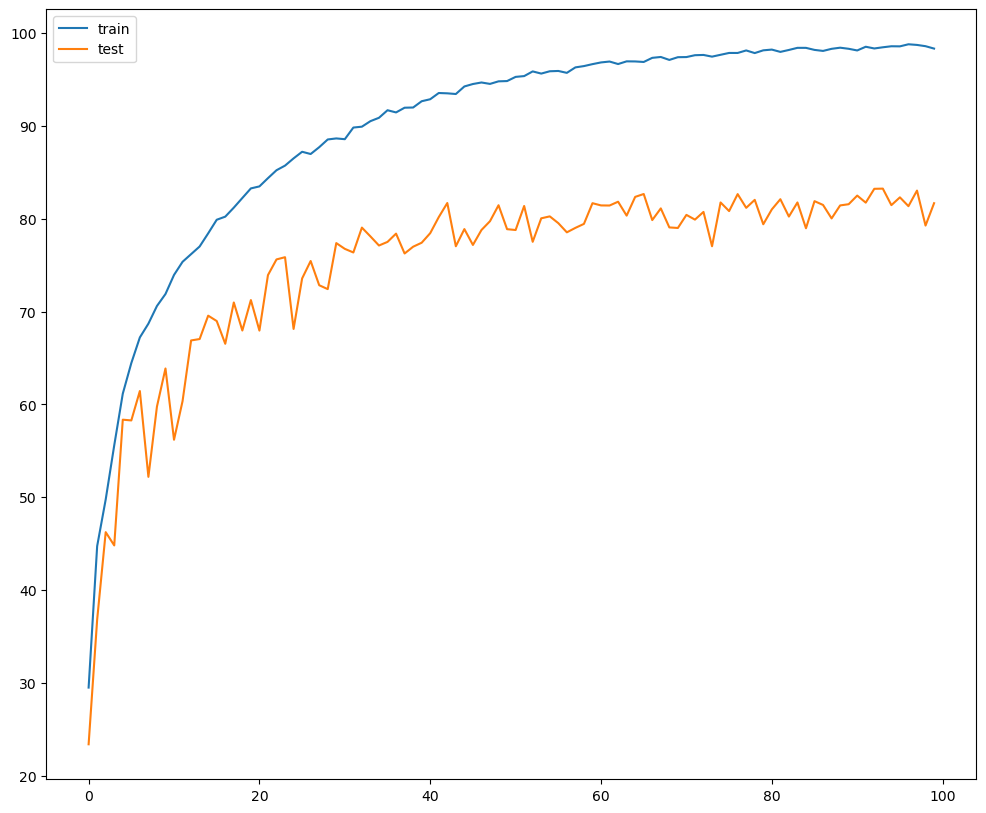

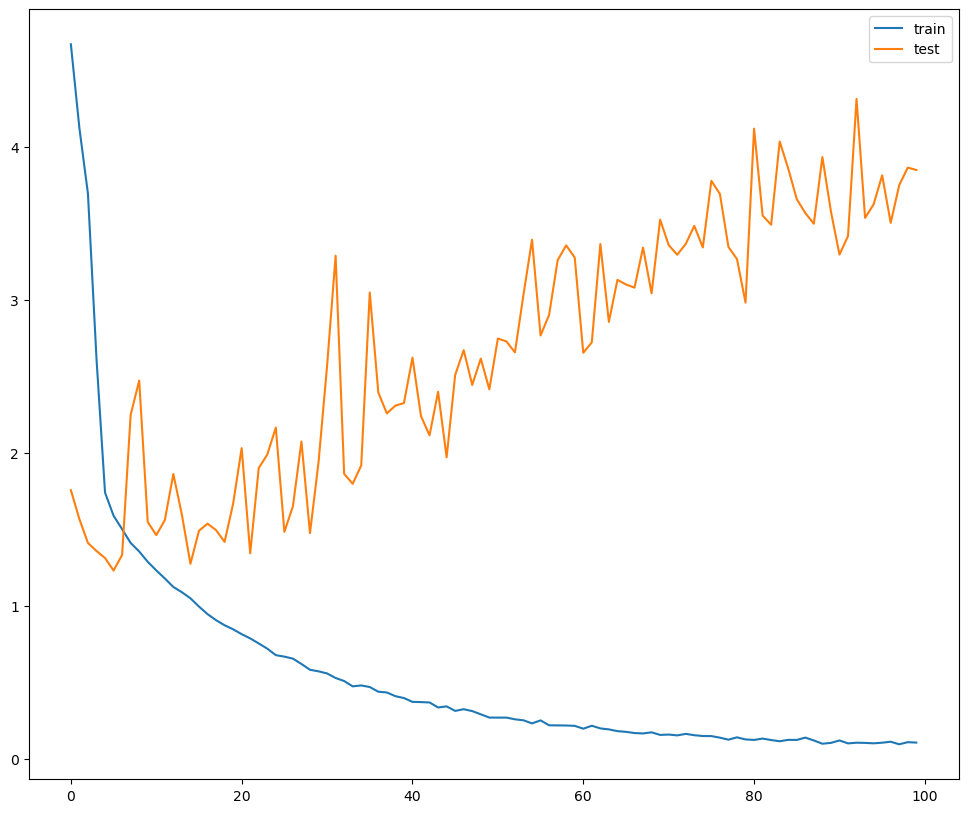

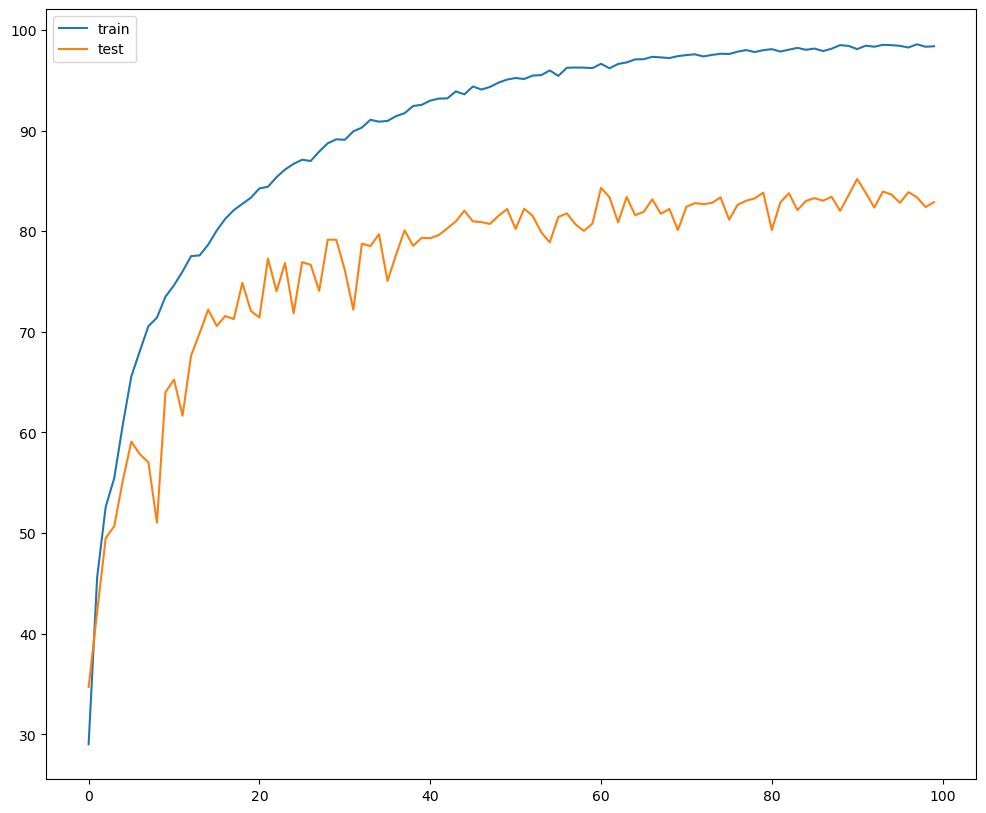

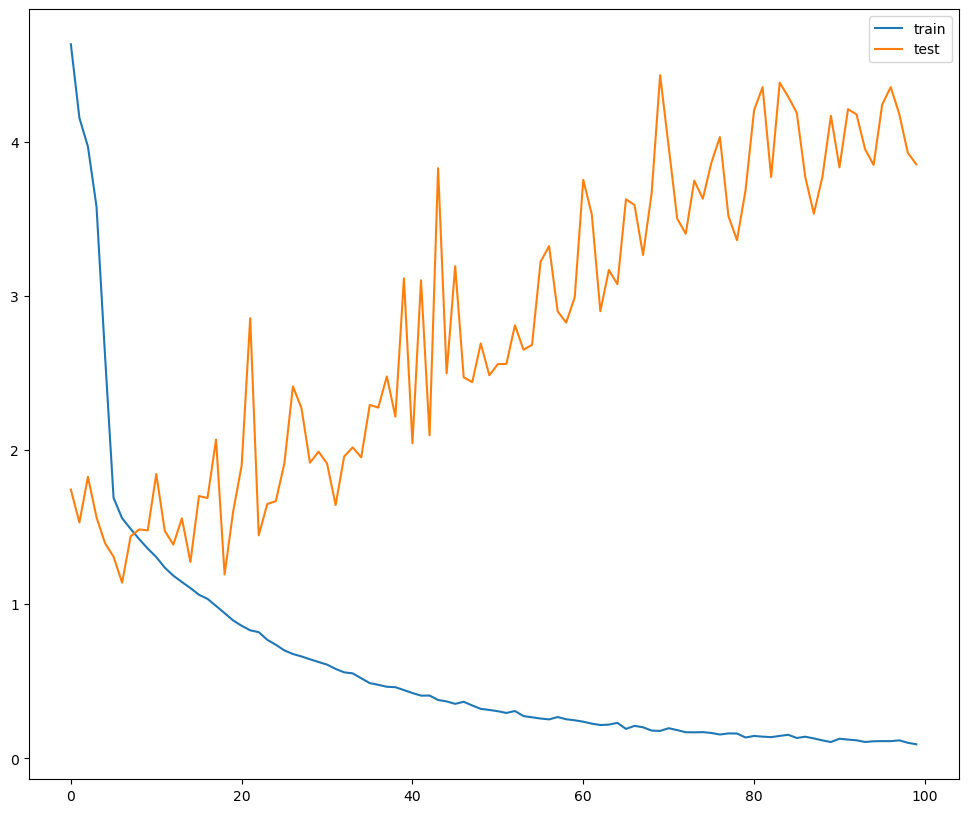

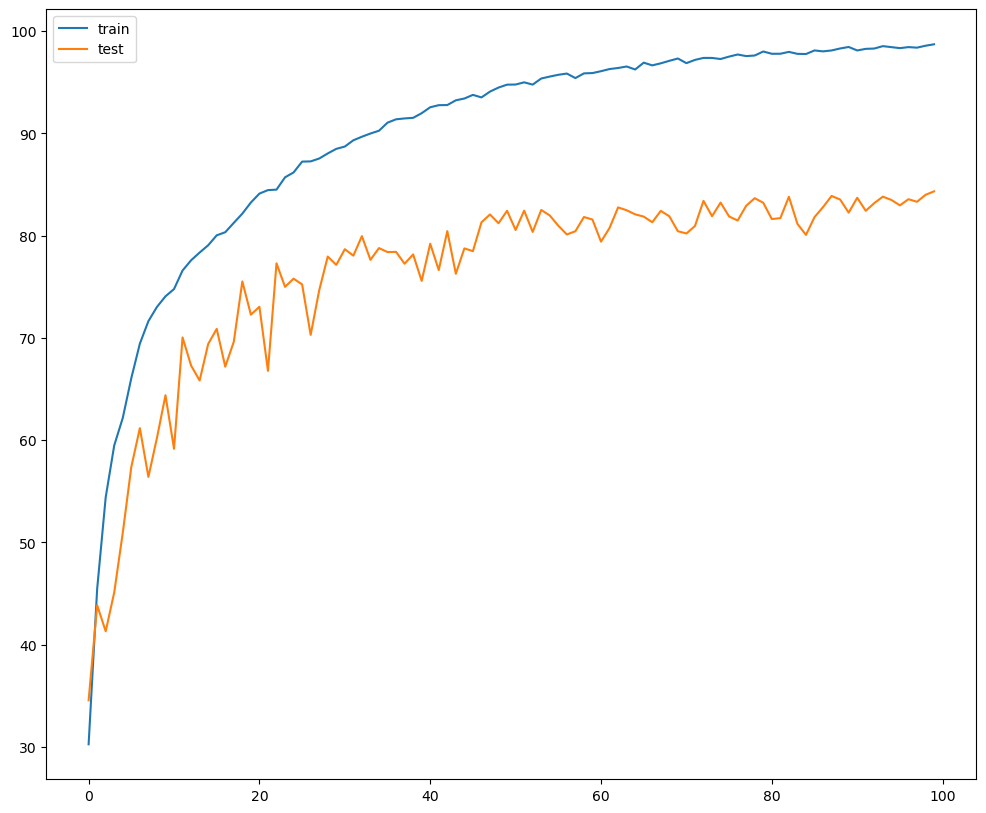

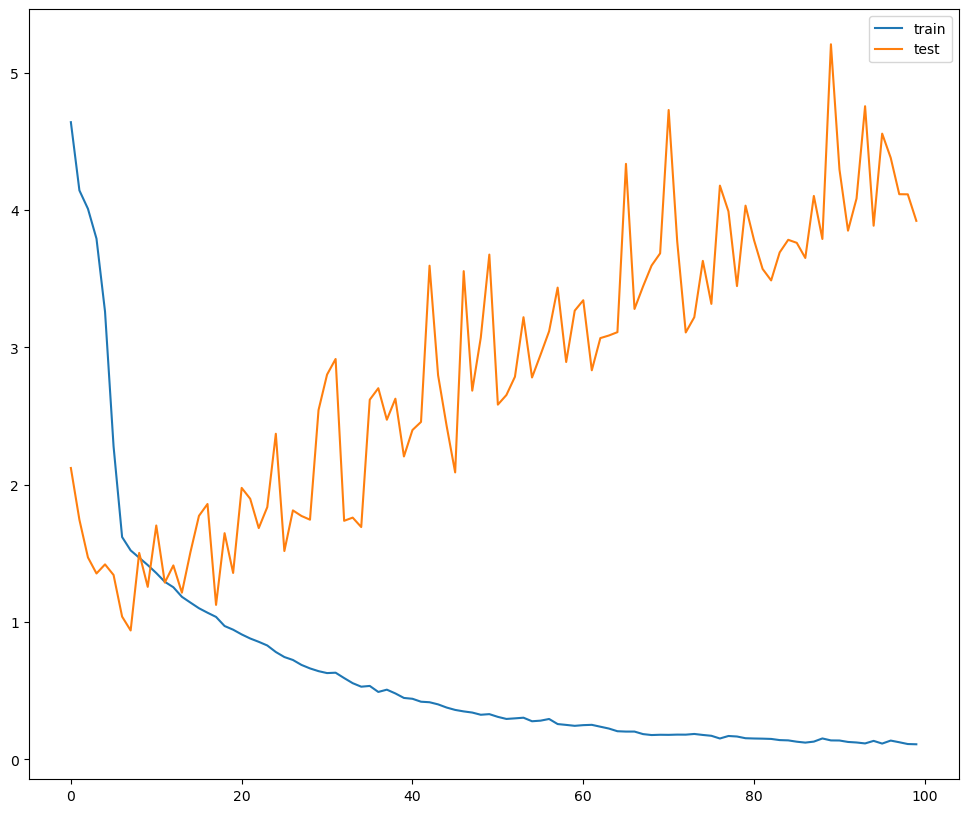

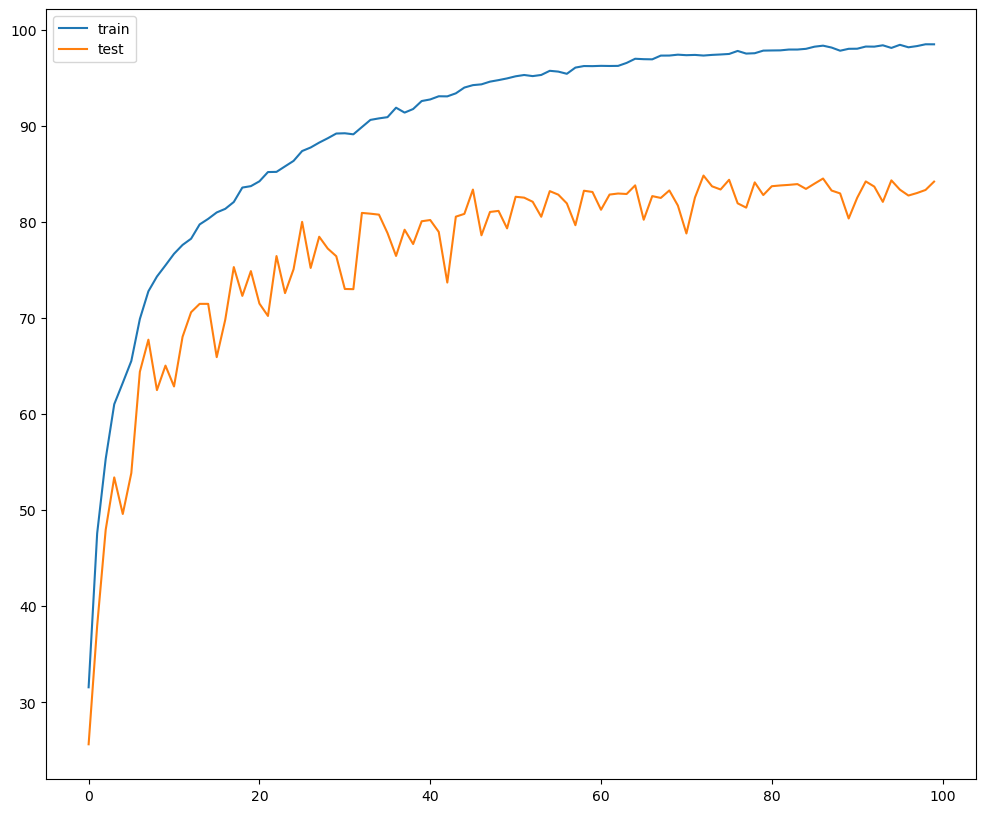

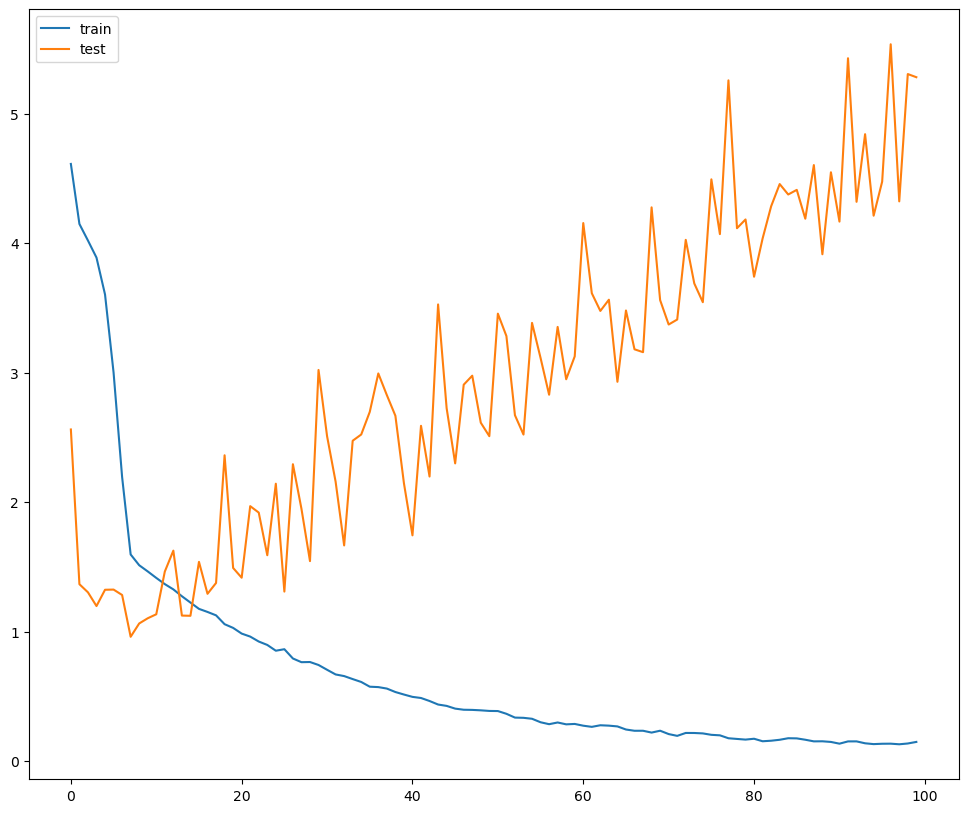

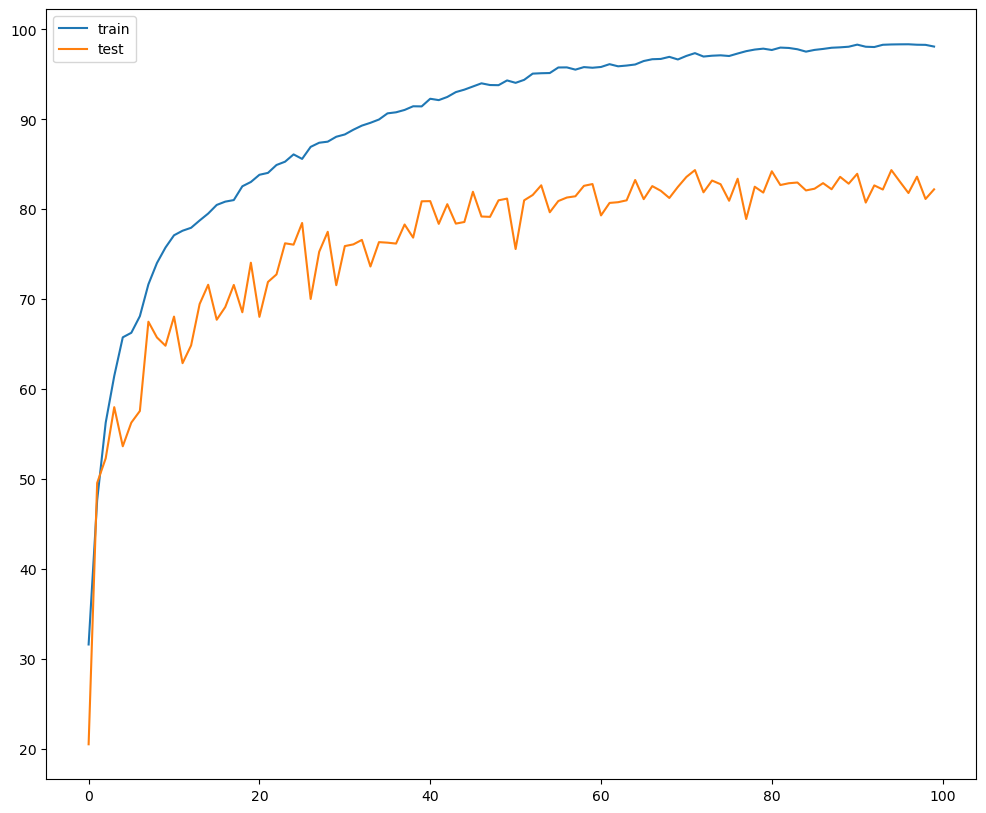

In [8]:
temp_list = list(range(1,11))
acc_list = []
for temp in temp_list:
    student = resnet18(pretrained=False)
    student_acc,_ = train(model=student,gpu='0,1,2,3,4,5,6,7',fig_name=f'34student_temp{temp}',kd_tag=True,teacher=teacher,temp=temp)
    acc_list.append(student_acc)

acc_list

Text(0.5, 1.0, 'acc-temperature')

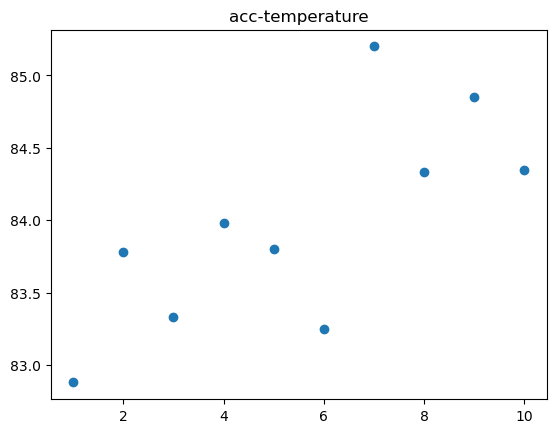

In [9]:
plt.figure()
plt.scatter(temp_list,acc_list)
plt.title('acc-temperature')

## 初步结论
- temperature越高，teacher的知识就越平滑，越低，则teacher的知识越接近one-hot编码形式
- 如果teacher存在overfitting现象（如：resnet50），那较高的temperature可能会给student更好的知识
- 如果teacher本身的overfitting不严重（如：resnet34），那么temperature就不用那么高，适当更好